$$sd = \frac{\sqrt{\sum (x_i - \mu)^2}}{N}$$

$$\mu = \frac{\sum x_i}{N}$$

$$RWI_i = \frac{x_i - \mu}{sd}$$

$$\sum (x_i \times P(i)) = \text{poor} \space (\pm 0.01 \times \text{population})$$

$$x_i \in [0,1]$$

# Poor Children Impact Analysis (Sigmoid - Slope Optimization)

This notebook explores an approach to disaggregate official poverty rates into lower geospatial resolution using Relative Wealth Index (RWI) so that it can inform impact analysis.

**NOTE: This version optimizes the SLOPE parameter with threshold fixed at RWI=0 (where poverty probability = 50%).**

## Methodology

1. Use children population (ages 0-5 + 5-15)
2. Classify tiles as Rural, Urban (based on SMOD), or Kingston Metropolitan Area (KMA = Kingston + Saint Andrew)
3. Calculate target poor children per classification: Total children in classification × Poverty rate
4. Calculate proportion of poor children per cell


### The Problem with Binary Selection
The previous method ranks cells by RWI and selects the poorest top-N cells until a population target is met. This assumes:
1.  **Ecological Fallacy**: All children in a "poor" cell are poor.
2.  **No Spillover**: No children in a "rich" cell are poor.

### The Sigmoid Solution
Model the relationship between Wealth (RWI) and Poverty as a **Logistic (Sigmoid) Curve**.

The "proportion" value represents the **proportion of poor children** in that cell, not a binary selection probability.
-   Very poor cells have a high poverty rate (e.g., 95% of children are poor).
-   Middle-income cells have a moderate poverty rate (e.g., 50% of children are poor).
-   Wealthy cells have a low poverty rate (e.g., 5% of children are poor).

**Key Point**: **ALL cells contribute proportionally** to the total poor children count:
-   A cell with poverty_rate = 0.30 → 30% of children in that cell are poor
-   Poor children = poverty_rate × children_population for **every cell**
-   Total poor children = Σ(poverty_rate × children_population) for **ALL cells**

**Optimization Approach**: Fix threshold at RWI=0 (where poverty probability = 50%) and optimize the **slope** parameter so that the **sum of expected poor children across all cells** exactly equals the poverty targets for each region (Rural, Urban, KMA).


## Configuration

Set the paths and parameters here:


In [1]:
# ============================================================================
# CONFIGURATION
# ============================================================================

# Base directory where downloaded files are located
BASE_DIR = "data"

# Country identifier
COUNTRY = "JAM"

# Impact probability data configuration (optional - for calculating potentially impacted poor children)
DATE = "2025-10-27"  # Format: YYYY-MM-DD
FORECAST_TIME = "000000"  # Format: HHMMSS (e.g., "000000" for midnight, "120000" for noon)
WIND_THRESHOLDS = ["34", "50", "64"]  # List of wind thresholds in knots to compare (e.g., ["34", "50", "64"])
STORM = "MELISSA"  # Storm name

# ============================================================================
# POVERTY RATES BY CLASSIFICATION
# ============================================================================

# Moderate poverty rates (%) for children (ages 0-15) by area classification 2022
POVERTY_RATE_RURAL = 34.6460305820465
POVERTY_RATE_URBAN = 22.9166205159144
POVERTY_RATE_KMA = 34.5674892972073  # Kingston Metropolitan Area (Kingston + Saint Andrew)

POVERTY_RATES = {
    "Rural": POVERTY_RATE_RURAL,
    "Urban": POVERTY_RATE_URBAN,
    "KMA": POVERTY_RATE_KMA
}

# SMOD classification threshold (>= 20 = urban, < 20 = rural)
SMOD_URBAN_THRESHOLD = 20.0

# Kingston Metropolitan Area parishes
KMA_PARISHES = ["Kingston", "Saint Andrew"]

print("# Poverty Rates by Classification (for children ages 0-15):")
print(f"  Rural: {POVERTY_RATE_RURAL:.2f}%")
print(f"  Urban: {POVERTY_RATE_URBAN:.2f}%")
print(f"  KMA (Kingston + Saint Andrew): {POVERTY_RATE_KMA:.2f}%")
print(f"\nSMOD Urban Threshold: >= {SMOD_URBAN_THRESHOLD}")
print(f"KMA Parishes: {', '.join(KMA_PARISHES)}")


# Poverty Rates by Classification (for children ages 0-15):
  Rural: 34.65%
  Urban: 22.92%
  KMA (Kingston + Saint Andrew): 34.57%

SMOD Urban Threshold: >= 20.0
KMA Parishes: Kingston, Saint Andrew


## Import Libraries


In [2]:
import os
import math
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')
    except:
        plt.style.use('default')
sns.set_palette("husl")

plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# ============================================================================
# VISUALIZATION SAVING SETUP
# ============================================================================
# Set to True to save all visualizations to a folder
SAVE_VISUALIZATIONS = True
VISUALIZATIONS_DIR = "analysis_output/visualizations"

if SAVE_VISUALIZATIONS:
    os.makedirs(VISUALIZATIONS_DIR, exist_ok=True)
    print(f"Visualizations will be saved to: {VISUALIZATIONS_DIR}/")
else:
    print("Visualization saving is disabled (set SAVE_VISUALIZATIONS = True to enable)")

# plt.show() to automatically save meaningful figures before showing
_original_show = plt.show
_figure_counter = {'count': 0}

def _show_with_save(*args, **kwargs):
    """Wrapper around plt.show() that saves meaningful figures automatically"""
    if SAVE_VISUALIZATIONS:
        fig = plt.gcf()
        axes = fig.get_axes()
        
        # Only save if figure has meaningful content (has axes with titles or suptitle)
        filename = None
        
        if axes:
            # Check for suptitle (main title) first
            try:
                if fig._suptitle is not None:
                    suptitle = fig._suptitle.get_text()
                    if suptitle and suptitle.strip():
                        # Create filename from suptitle
                        filename = suptitle.lower().replace(' ', '_').replace('\n', '_')
                        filename = ''.join(c for c in filename if c.isalnum() or c in '_-')
            except:
                pass
            
            # Check for axis titles if no suptitle
            if not filename:
                for ax in axes:
                    try:
                        title = ax.get_title()
                        if title and title.strip():
                            filename = title.lower().replace(' ', '_').replace('\n', '_')
                            filename = ''.join(c for c in filename if c.isalnum() or c in '_-')
                            break
                    except:
                        pass
        
        if filename:
            # Save directly to visualizations directory using the title as filename
            filepath = os.path.join(VISUALIZATIONS_DIR, f"{filename}.png")
            fig.savefig(filepath, dpi=300, bbox_inches='tight', facecolor='white')
            print(f"  Saved: {filepath}")
    
    return _original_show(*args, **kwargs)

# Replace plt.show with our wrapper
if SAVE_VISUALIZATIONS:
    plt.show = _show_with_save
    print("  Auto-saving enabled: Figures will be saved using their titles")

Visualizations will be saved to: analysis_output/visualizations/
  Auto-saving enabled: Figures will be saved using their titles


## Load Data Files


In [3]:
# Construct file paths
# Base admin boundaries file
admin_base_path = os.path.join(BASE_DIR, "geodb", "aos_views", "admin_views", f"{COUNTRY}_admin1.parquet")

# Base tile file (14-level tiles with population and RWI)
tiles_base_path = os.path.join(BASE_DIR, "geodb", "aos_views", "mercator_views", f"{COUNTRY}_14.parquet")

print(f"Loading data files...")
print(f"  Admin boundaries: {admin_base_path}")
print(f"  Tiles: {tiles_base_path}")

# Load base admin boundaries
if os.path.exists(admin_base_path):
    gdf_admin = gpd.read_parquet(admin_base_path)
    print(f"\nLoaded admin boundaries: {len(gdf_admin)} parishes")
    print(f"   Columns: {list(gdf_admin.columns)}")
else:
    raise FileNotFoundError(f"Admin boundaries file not found: {admin_base_path}")

# Load base tiles with population and RWI
if os.path.exists(tiles_base_path):
    gdf_tiles = gpd.read_parquet(tiles_base_path)
    print(f"\nLoaded tiles: {len(gdf_tiles)} cells")
    print(f"   Columns: {list(gdf_tiles.columns)}")
else:
    raise FileNotFoundError(f"Tiles file not found: {tiles_base_path}")


Loading data files...
  Admin boundaries: data/geodb/aos_views/admin_views/JAM_admin1.parquet
  Tiles: data/geodb/aos_views/mercator_views/JAM_14.parquet

Loaded admin boundaries: 14 parishes
   Columns: ['tile_id', 'school_age_population', 'infant_population', 'built_surface_m2', 'population', 'num_schools', 'num_hcs', 'smod_class', 'rwi', 'name', 'geometry']

Loaded tiles: 2231 cells
   Columns: ['tile_id', 'school_age_population', 'infant_population', 'population', 'built_surface_m2', 'smod_class', 'num_schools', 'num_hcs', 'rwi', 'geometry', 'id']


## Prepare Data for Analysis


In [4]:
# Identify the correct column names
# Try to find RWI column
rwi_column = None
for col in gdf_tiles.columns:
    if col.lower() == 'rwi' or col.lower() == 'relative_wealth_index':
        rwi_column = col
        break

if rwi_column is None:
    rwi_cols = [col for col in gdf_tiles.columns if 'rwi' in col.lower()]
    if rwi_cols:
        rwi_column = rwi_cols[0]

# Try to find children population columns (0-5 and 5-15)
infant_col = None
school_age_col = None
for col in gdf_tiles.columns:
    if 'infant' in col.lower() or '0-5' in col.lower():
        infant_col = col
    if 'school_age' in col.lower() or '5-15' in col.lower():
        school_age_col = col

# Try to find tile_id column
tile_id_column = None
for col in gdf_tiles.columns:
    if col.lower() in ['tile_id', 'tileid', 'id', 'zone_id']:
        tile_id_column = col
        break

print(f"Identified columns:")
print(f"  RWI column: {rwi_column}")
print(f"  Infant population (0-5): {infant_col}")
print(f"  School age population (5-15): {school_age_col}")
print(f"  Tile ID column: {tile_id_column}")

if rwi_column is None:
    print("\nWarning: Could not find RWI column")
    print(f"   Available columns: {list(gdf_tiles.columns)}")
    raise ValueError("Required column (RWI) not found")

if infant_col is None or school_age_col is None:
    print("\nWarning: Could not find children population columns")
    print(f"   Available columns: {list(gdf_tiles.columns)}")
    raise ValueError("Required columns (infant_population and school_age_population) not found")

# Create a working copy of tiles
gdf_work = gdf_tiles.copy()

# Ensure we have the necessary columns with standardized names
gdf_work['rwi'] = gdf_work[rwi_column]
gdf_work['infant_population'] = gdf_work[infant_col].fillna(0)
gdf_work['school_age_population'] = gdf_work[school_age_col].fillna(0)
gdf_work['children_population'] = gdf_work['infant_population'] + gdf_work['school_age_population']

if tile_id_column:
    gdf_work['tile_id'] = gdf_work[tile_id_column]
else:
    gdf_work['tile_id'] = gdf_work.index

# Remove rows with missing RWI or zero children population
gdf_work = gdf_work[gdf_work['rwi'].notna() & (gdf_work['children_population'] > 0)].copy()

print(f"\nPrepared {len(gdf_work)} tiles with valid RWI and children population data")
print(f"  Total children population: {gdf_work['children_population'].sum():,.0f}")
print(f"  - Ages 0-5: {gdf_work['infant_population'].sum():,.0f}")
print(f"  - Ages 5-15: {gdf_work['school_age_population'].sum():,.0f}")


Identified columns:
  RWI column: rwi
  Infant population (0-5): infant_population
  School age population (5-15): school_age_population
  Tile ID column: tile_id

Prepared 2224 tiles with valid RWI and children population data
  Total children population: 845,814
  - Ages 0-5: 217,525
  - Ages 5-15: 628,289


## Spatial Join: Assign Tiles to Parishes and Classify


In [5]:
# Perform spatial join to assign each tile to a parish
# Ensure both GeoDataFrames have the same CRS
if gdf_work.crs != gdf_admin.crs:
    gdf_work = gdf_work.to_crs(gdf_admin.crs)

# Start with a copy of all original tiles - we will assign parishes one by one
# This ensures we never lose any tiles
gdf_tiles_with_admin = gdf_work.copy()
gdf_tiles_with_admin['parish'] = None

print(f"Assigning {len(gdf_tiles_with_admin)} tiles to parishes...")

# For each tile, determine its parish assignment
for idx, tile_row in gdf_tiles_with_admin.iterrows():
    tile_geom = tile_row.geometry
    tile_centroid = tile_geom.centroid
    assigned_parish = None
    
    # Step 1: Check if tile intersects any parish
    intersecting_parishes = []
    for admin_idx, admin_row in gdf_admin.iterrows():
        if tile_geom.intersects(admin_row.geometry):
            intersecting_parishes.append(admin_row['name'])
    
    if len(intersecting_parishes) == 1:
        # Tile intersects exactly one parish - assign to it
        assigned_parish = intersecting_parishes[0]
    elif len(intersecting_parishes) > 1:
        # Tile intersects multiple parishes - use centroid to decide
        centroid_gdf = gpd.GeoDataFrame([{'geometry': tile_centroid}], crs=gdf_admin.crs)
        centroid_join = gpd.sjoin(centroid_gdf, gdf_admin[['name', 'geometry']], how='left', predicate='within')
        
        if len(centroid_join) > 0 and centroid_join['name'].iloc[0] is not None:
            # Centroid falls within one of the intersecting parishes
            assigned_parish = centroid_join['name'].iloc[0]
        else:
            # Centroid doesn't fall within any parish, use nearest
            min_dist = float('inf')
            for admin_idx, admin_row in gdf_admin.iterrows():
                if admin_row['name'] in intersecting_parishes:  # Only check intersecting parishes
                    dist = tile_centroid.distance(admin_row.geometry)
                    if dist < min_dist:
                        min_dist = dist
                        assigned_parish = admin_row['name']
    else:
        # Tile doesn't intersect any parish - assign to nearest parish
        min_dist = float('inf')
        for admin_idx, admin_row in gdf_admin.iterrows():
            dist = tile_centroid.distance(admin_row.geometry)
            if dist < min_dist:
                min_dist = dist
                assigned_parish = admin_row['name']
    
    # Assign the parish
    if assigned_parish:
        gdf_tiles_with_admin.loc[idx, 'parish'] = assigned_parish
    else:
        print(f"Warning: Could not assign parish to tile {idx}")

# Verify all tiles have a parish
final_missing = gdf_tiles_with_admin['parish'].isna().sum()
if final_missing > 0:
    print(f"\nWarning: {final_missing} tiles still missing parish assignment")
    # Last resort: assign remaining tiles to nearest parish
    for idx in gdf_tiles_with_admin[gdf_tiles_with_admin['parish'].isna()].index:
        tile_centroid = gdf_tiles_with_admin.loc[idx, 'geometry'].centroid
        min_dist = float('inf')
        nearest_parish = None
        for admin_idx, admin_row in gdf_admin.iterrows():
            dist = tile_centroid.distance(admin_row.geometry)
            if dist < min_dist:
                min_dist = dist
                nearest_parish = admin_row['name']
        if nearest_parish:
            gdf_tiles_with_admin.loc[idx, 'parish'] = nearest_parish

# Final verification
final_missing = gdf_tiles_with_admin['parish'].isna().sum()
if final_missing > 0:
    print(f"\nError: {final_missing} tiles still missing parish assignment after all attempts")
else:
    print(f"\n✓ All {len(gdf_tiles_with_admin)} tiles successfully assigned to parishes")

# Ensure required columns exist
if 'rwi' not in gdf_tiles_with_admin.columns:
    rwi_cols = [col for col in gdf_tiles_with_admin.columns if 'rwi' in col.lower()]
    if rwi_cols:
        gdf_tiles_with_admin['rwi'] = gdf_tiles_with_admin[rwi_cols[0]]
    else:
        raise ValueError("RWI column not found after spatial join")

print(f"\nAssigned {len(gdf_tiles_with_admin)} tiles to parishes")
print(f"Parishes found:")
print(gdf_tiles_with_admin['parish'].value_counts().sort_index())


Assigning 2224 tiles to parishes...


✓ All 2224 tiles successfully assigned to parishes

Assigned 2224 tiles to parishes
Parishes found:
parish
Clarendon          240
Hanover            100
Kingston             4
Manchester         159
Portland           171
Saint Andrew        94
Saint Ann          240
Saint Catherine    239
Saint Elizabeth    235
Saint James        119
Saint Mary         131
Saint Thomas       157
Trelawny           170
Westmoreland       165
Name: count, dtype: int64


  Saved: analysis_output/visualizations/assigned_tiles_per_parish_2224_tiles_assigned_to_14_parishes.png


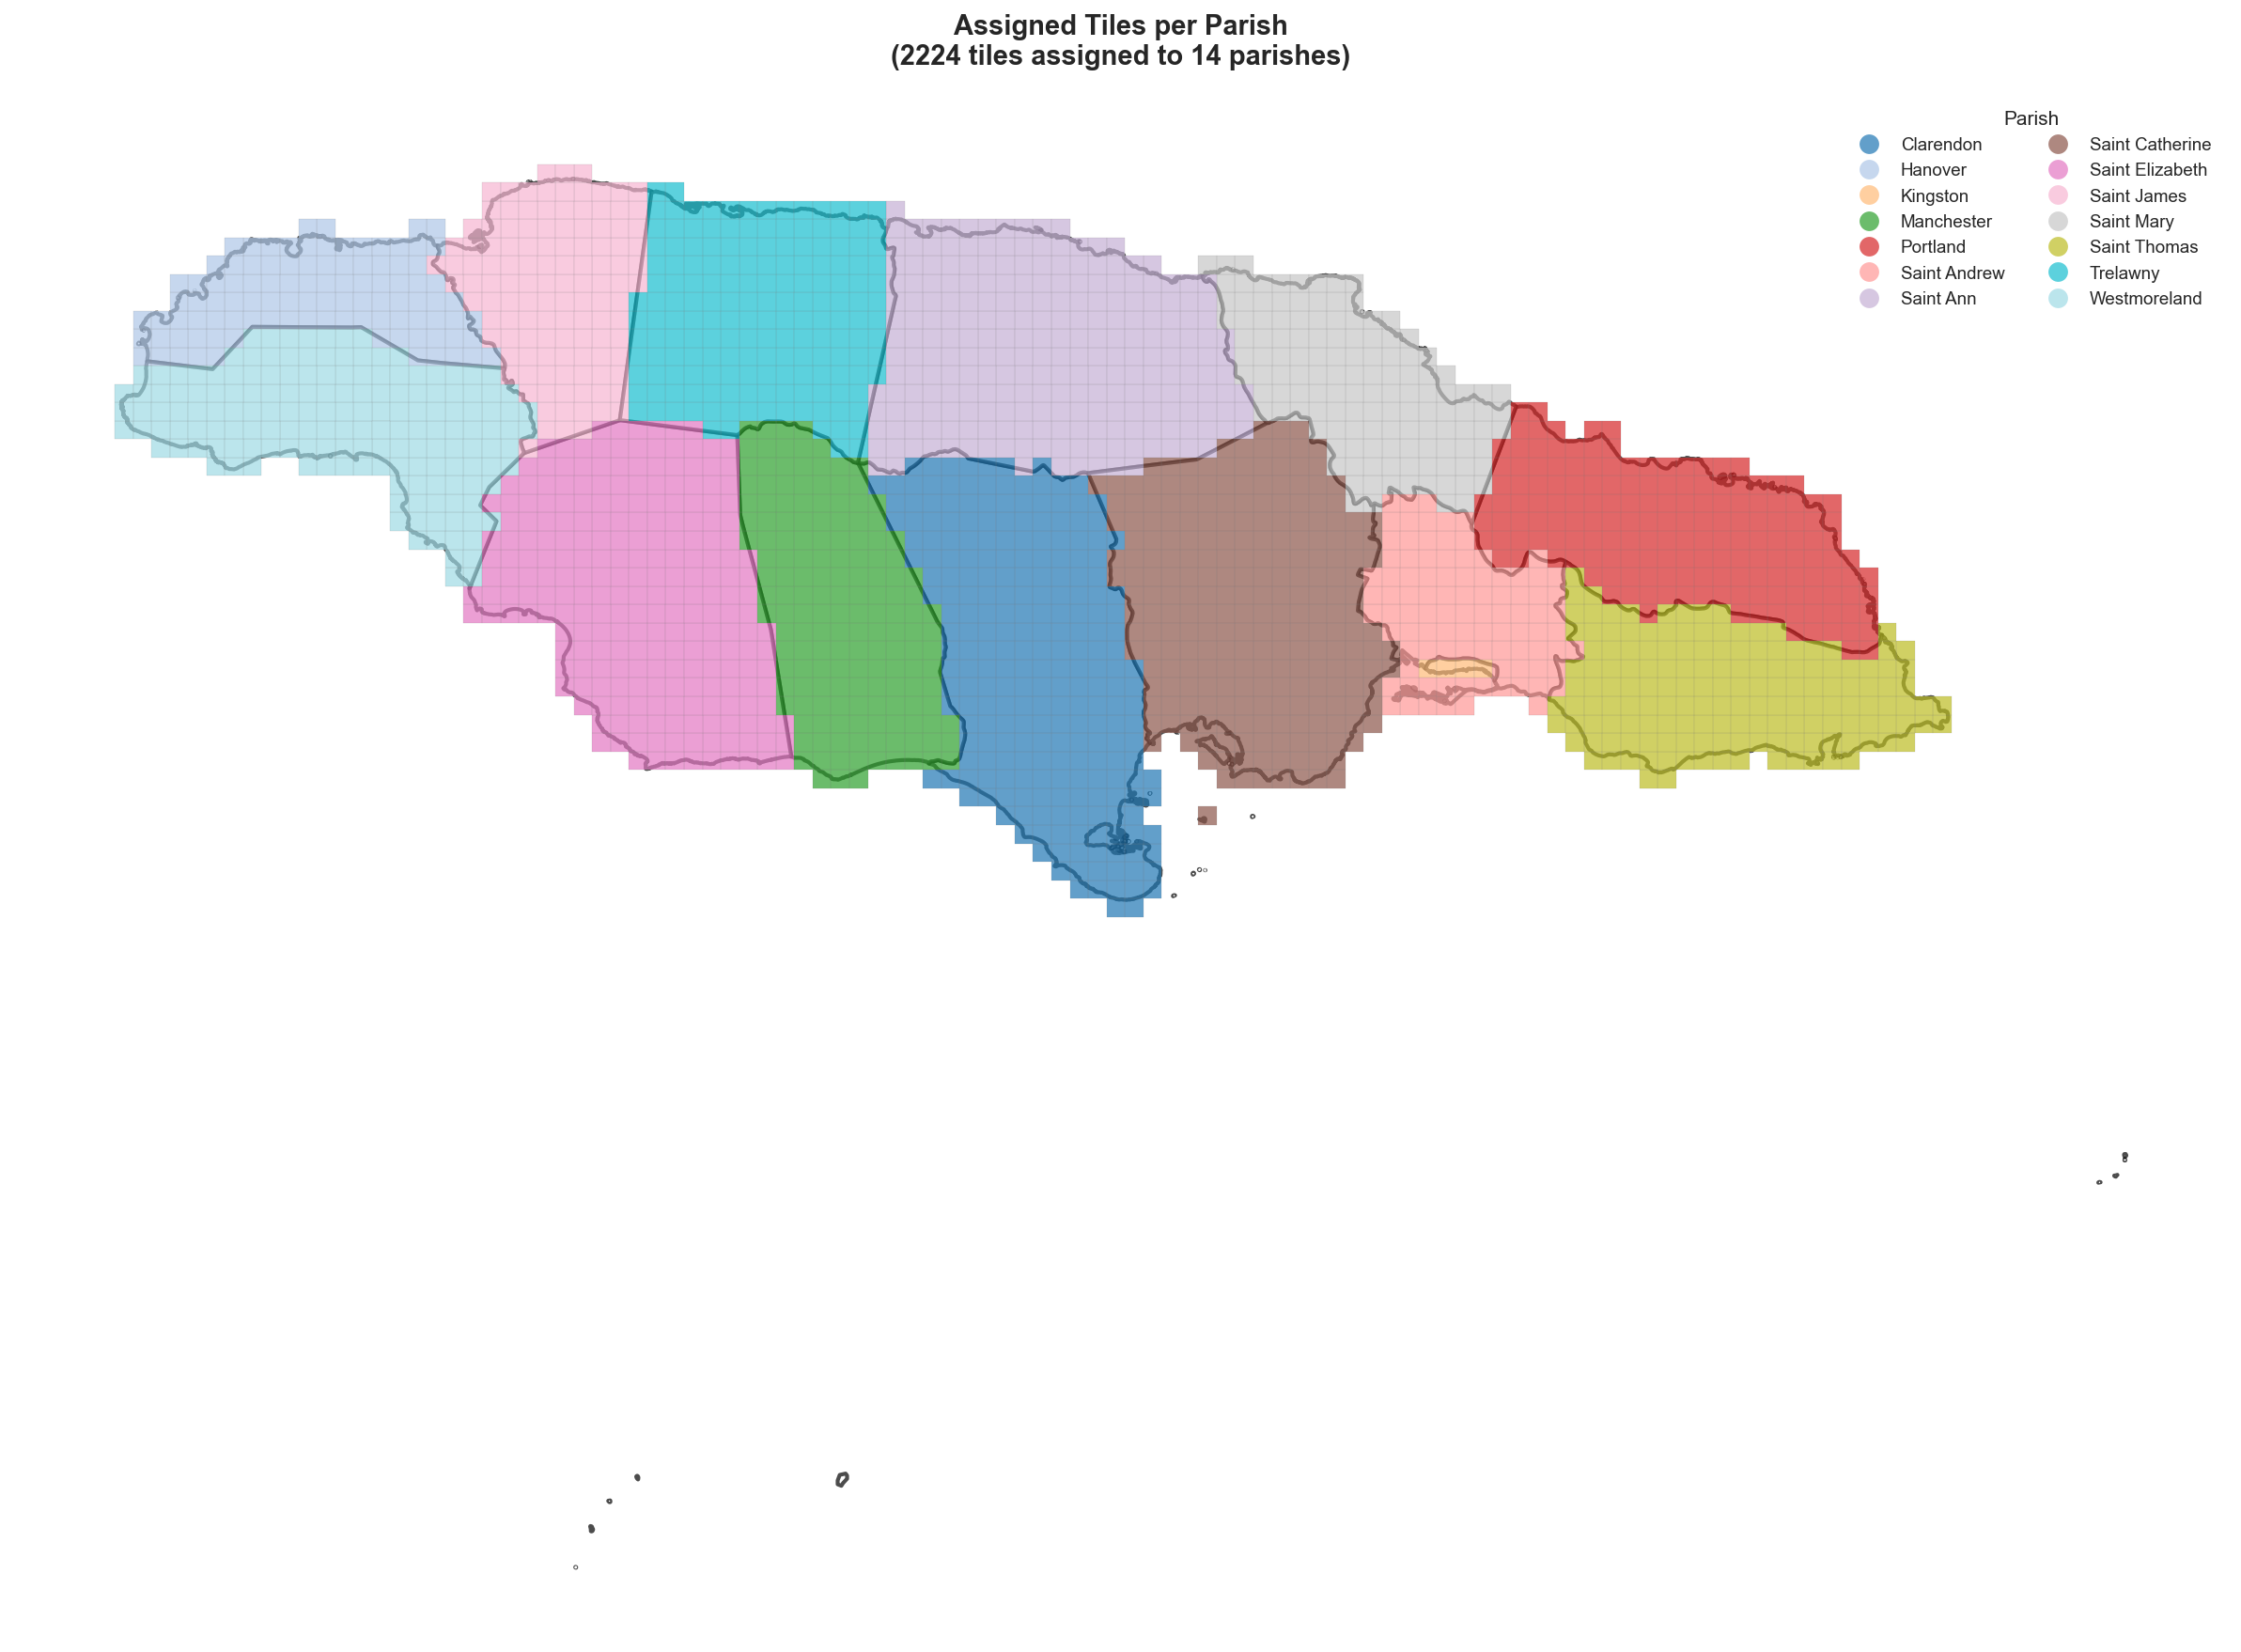


Tile assignment summary:
  Total tiles assigned: 2224
  Parishes: 14
  Tiles per parish:
    Clarendon: 240 tiles
    Hanover: 100 tiles
    Kingston: 4 tiles
    Manchester: 159 tiles
    Portland: 171 tiles
    Saint Andrew: 94 tiles
    Saint Ann: 240 tiles
    Saint Catherine: 239 tiles
    Saint Elizabeth: 235 tiles
    Saint James: 119 tiles
    Saint Mary: 131 tiles
    Saint Thomas: 157 tiles
    Trelawny: 170 tiles
    Westmoreland: 165 tiles


In [6]:
# Visualize assigned tiles per parish
fig, ax = plt.subplots(figsize=(16, 12))

# Plot parish boundaries
gdf_admin.plot(ax=ax, color='white', edgecolor='black', linewidth=2, alpha=0.7, label='Parish Boundaries')

# Plot tiles colored by parish
if len(gdf_tiles_with_admin) > 0:
    gdf_tiles_with_admin.plot(
        ax=ax, 
        column='parish', 
        categorical=True, 
        cmap='tab20', 
        alpha=0.7, 
        markersize=2, 
        edgecolor='gray',
        linewidth=0.1,
        legend=True, 
        legend_kwds={
            'loc': 'upper right',
            'fontsize': 9, 
            'ncol': 2,
            'title': 'Parish',
            'title_fontsize': 10
        }
    )

ax.set_title(f'Assigned Tiles per Parish\n({len(gdf_tiles_with_admin)} tiles assigned to {gdf_tiles_with_admin["parish"].nunique()} parishes)', 
             fontsize=14, fontweight='bold', pad=15)
ax.axis('off')

plt.tight_layout()
plt.show()

print(f"\nTile assignment summary:")
print(f"  Total tiles assigned: {len(gdf_tiles_with_admin)}")
print(f"  Parishes: {gdf_tiles_with_admin['parish'].nunique()}")
print(f"  Tiles per parish:")
parish_counts = gdf_tiles_with_admin['parish'].value_counts().sort_index()
for parish, count in parish_counts.items():
    print(f"    {parish}: {count} tiles")


In [7]:
def classify_area(parish, smod_class):
    """
    Classify tile as KMA, Urban, or Rural.
    Priority: KMA > Urban > Rural
    """
    # Check if in KMA first
    if parish in KMA_PARISHES:
        return "KMA"

    # Then check SMOD for urban/rural
    if smod_class is None or math.isnan(smod_class):
        return "unknown"
    elif smod_class >= SMOD_URBAN_THRESHOLD:
        return "Urban"
    else:
        return "Rural"



# Classify each tile
gdf_tiles_with_admin['area_classification'] = gdf_tiles_with_admin.apply(
    lambda row: classify_area(row['parish'], row['smod_class']), axis=1
)

# Remove tiles with unknown classification
gdf_tiles_with_admin = gdf_tiles_with_admin[gdf_tiles_with_admin['area_classification'] != 'unknown'].copy()

# Print classification summary
print("\n" + "=" * 60)
print("Area Classification Summary:")
print("=" * 60)
classification_counts = gdf_tiles_with_admin['area_classification'].value_counts()
for classification, count in classification_counts.items():
    children_pop = gdf_tiles_with_admin[gdf_tiles_with_admin['area_classification'] == classification]['children_population'].sum()
    print(f"{classification}:")
    print(f"  Tiles: {count}")
    print(f"  Children population: {children_pop:,.0f}")

# Calculate targets per classification
print("\n" + "=" * 60)
print("Target Calculation (Total children × Poverty rate):")
print("=" * 60)
classification_targets = {}
for classification in ['KMA', 'Urban', 'Rural']:
    classification_tiles = gdf_tiles_with_admin[gdf_tiles_with_admin['area_classification'] == classification]
    if len(classification_tiles) > 0:
        total_children_pop = classification_tiles['children_population'].sum()

        # Get poverty rate
        if classification == 'KMA':
            poverty_rate = POVERTY_RATE_KMA / 100
        elif classification == 'Urban':
            poverty_rate = POVERTY_RATE_URBAN / 100
        elif classification == 'Rural':
            poverty_rate = POVERTY_RATE_RURAL / 100

        # Calculate target: total children × poverty rate
        target_poor_children = total_children_pop * poverty_rate
        classification_targets[classification] = target_poor_children

        print(f"\n{classification}:")
        print(f"  Total children population: {total_children_pop:,.0f}")
        print(f"  Poverty rate: {poverty_rate*100:.2f}%")
        print(f"  Target poor children: {target_poor_children:,.0f}")


Area Classification Summary:
Rural:
  Tiles: 1976
  Children population: 411,510
Urban:
  Tiles: 150
  Children population: 248,419
KMA:
  Tiles: 98
  Children population: 185,885

Target Calculation (Total children × Poverty rate):

KMA:
  Total children population: 185,885
  Poverty rate: 34.57%
  Target poor children: 64,256

Urban:
  Total children population: 248,419
  Poverty rate: 22.92%
  Target poor children: 56,929

Rural:
  Total children population: 411,510
  Poverty rate: 34.65%
  Target poor children: 142,572


## Implement Poor Children Identification Methodology

Define the sigmoid function and calibration method for calculating poverty rates.

**Key Functions**:
- `sigmoid()`: Calculates poverty rate from RWI using logistic function
- `calibrate_poverty_curve()`: Finds optimal **slope** to match official poverty statistics (with threshold fixed at RWI=0)

Proportion of poor $P(i)$ is defined as:

$$P(i) = \frac{1}{1 + e^{slope \cdot (RWI_i - threshold)}}$$

- **threshold**: Fixed at RWI=0 (where poverty probability = 50%)
- **slope**: Controls the "steepness" (inequality). Higher slope = sharper divide between rich/poor. **This is optimized.**

Find the **slope** that satisfies:
$$\sum (P(i) \times \text{Population}_i) = \text{Target Poor Children}$$

where threshold = 0.


### Optimization

The optimization process uses root finding to solve for the slope parameter (with threshold fixed at 0):

1. **Objective Function**: For a given slope value, calculate:
   - The poverty proportion for each cell using the sigmoid function (with threshold=0)
   - The expected poor children: $\sum_i (P(i) \times \text{Population}_i)$
   - The error: `Expected Poor Children - Target Poor Children`

2. **Root Finding Algorithm**: Brent's method (`scipy.optimize.brentq`) to find the slope where the error equals zero. This algorithm:
   - Requires the function to have opposite signs at two endpoints (bracketing)
   - Efficiently narrows down the search interval
   - Finds the exact slope where `Expected Poor Children = Target Poor Children`

3. **Visual Interpretation**:
   - If slope is too low -> More gradual transition, more cells contribute -> May have too many or too few poor children
   - If slope is too high -> Sharper transition, approaching binary -> May have too many or too few poor children
   - The optimal slope balances these to match the target exactly

The model's expected poor children will match the official poverty statistics exactly, while still providing nuanced proportion gradients across all cells.

In [8]:
from scipy import optimize

def sigmoid(rwi, threshold, slope):
    """Logistic function returning proportion of poor children [0, 1]."""
    # Note: Slope is positive in math, but since Lower RWI = Higher Poverty, invert the sign effectively by (RWI - Threshold).
    return 1 / (1 + np.exp(slope * (rwi - threshold)))


def calibrate_poverty_curve(df, target_pop, threshold=0.0, return_details=False):
    """
    Finds the optimal Slope parameter that results in the target population.
    Threshold is fixed at RWI=0 (where poverty probability = 50%).

    Parameters:
    -----------
    df : DataFrame
        DataFrame with 'rwi' and 'children_population' columns
    target_pop : float
        Target number of poor children
    threshold : float
        Fixed RWI threshold (default: 0.0, where poverty probability = 50%)
    return_details : bool
        If True, returns optimization details for visualization

    Returns:
    --------
    optimal_slope : float
        The slope parameter that achieves the target population
    (optional) details : dict
        Dictionary with optimization details if return_details=True
    """
    rwi_values = df['rwi'].values
    pop_values = df['children_population'].values

    # Objective function: Error between Calculated and Target
    def objective(slope):
        if slope <= 0:
            return float('inf')  # Slope must be positive
        probs = sigmoid(rwi_values, threshold, slope)
        total_estimated = np.sum(probs * pop_values)
        return total_estimated - target_pop

    # Find root (Slope where error = 0)
    # Try to find bounds where objective has opposite signs
    slope_min = 0.001  # Very small slope (almost flat)
    slope_max = 200.0  # Very large slope (almost step function)
    
    obj_min = objective(slope_min)
    obj_max = objective(slope_max)
    
    # If both have same sign, try to expand bounds
    if obj_min * obj_max > 0:
        # Try to find a better bracket by searching wider range
        for test_min in [0.0001, 0.001, 0.01]:
            for test_max in [50, 100, 200, 500]:
                obj_test_min = objective(test_min)
                obj_test_max = objective(test_max)
                if obj_test_min * obj_test_max < 0:
                    slope_min = test_min
                    slope_max = test_max
                    break
            if obj_test_min * obj_test_max < 0:
                break
    
    try:
        optimal_slope = optimize.brentq(objective, slope_min, slope_max)

        if return_details:
            # Calculate optimization curve for visualization
            slope_range = np.linspace(max(0.1, slope_min), min(10, slope_max), 200)
            errors = [objective(s) for s in slope_range]
            estimated_pops = [target_pop + err for err in errors]

            details = {
                'slope_range': slope_range,
                'errors': errors,
                'estimated_pops': estimated_pops,
                'optimal_slope': optimal_slope,
                'threshold': threshold,
                'target_pop': target_pop
            }
            return optimal_slope, details
        else:
            return optimal_slope
    except ValueError as e:
        print(f"Optimization failed! Target might be out of range. Error: {e}")
        print(f"  Objective at min ({slope_min}): {objective(slope_min):.2f}")
        print(f"  Objective at max ({slope_max}): {objective(slope_max):.2f}")
        if return_details:
            return None, {}
        return None

## Run Optimization per Region

Calibrate poverty rates for each region (Rural, Urban, KMA) to match official poverty statistics:

1. For each region, calculate target poor children from official poverty rates
2. Use root finding to find optimal RWI threshold
3. Apply sigmoid function to calculate poverty rate for each cell
4. Verify that total expected poor children matches target exactly

In [9]:
gdf_results = gdf_tiles_with_admin.copy()
gdf_results['poverty_prob'] = 0.0 # Poverty rate for each cell

# Fixed Threshold (RWI=0 where poverty probability = 50%)
THRESHOLD_PARAM = 0.0

calibration_stats = []

# Map area_classification to poverty rates
poverty_rate_map = {
    'Rural': POVERTY_RATE_RURAL / 100,
    'Urban': POVERTY_RATE_URBAN / 100,
    'KMA': POVERTY_RATE_KMA / 100
}

for region, rate in poverty_rate_map.items():
    # Filter Region
    mask = gdf_results['area_classification'] == region
    df_region = gdf_results[mask]
    
    if len(df_region) == 0:
        continue
    
    # Calculate Target
    total_pop = df_region['children_population'].sum()
    target_poor = total_pop * rate
    
    # Optimize slope (threshold fixed at 0)
    opt_slope = calibrate_poverty_curve(df_region, target_poor, threshold=THRESHOLD_PARAM)
    
    # Apply to all cells in region
    probs = sigmoid(df_region['rwi'], THRESHOLD_PARAM, opt_slope)
    gdf_results.loc[mask, 'poverty_prob'] = probs
    
    # Verify
    estimated_poor = (probs * df_region['children_population']).sum()
    
    calibration_stats.append({
        'Region': region,
        'Target': target_poor,
        'Achieved': estimated_poor,
        'Difference': estimated_poor - target_poor,
        'Optimal_Slope': opt_slope
    })
    
    print(f"{region}: Slope={opt_slope:.3f}, Target={target_poor:,.0f}, Achieved={estimated_poor:,.0f}")

df_stats = pd.DataFrame(calibration_stats)
print("-"*50)
print("\nCalibration Statistics:")
print(df_stats.to_string(index=False))

Rural: Slope=3.506, Target=142,572, Achieved=142,572
Urban: Slope=1.577, Target=56,929, Achieved=56,929
KMA: Slope=0.656, Target=64,256, Achieved=64,256
--------------------------------------------------

Calibration Statistics:
Region        Target      Achieved    Difference  Optimal_Slope
 Rural 142571.928804 142571.928804 -8.731149e-11       3.506394
 Urban  56929.171508  56929.171508 -7.275958e-12       1.576957
   KMA  64255.873011  64255.873011  7.275958e-12       0.656412


## Comparison: Sigmoid vs Binary Approach

Compare the sigmoid approach with the binary ranking method to highlight key differences.

1. Implements binary ranking method (selects cells until target is reached)
2. Compares statistics and visualizations between both approaches
3. Shows how poor children are assigned differently:
   - Binary: Only selected cells contribute (100% poor in those cells)
   - Sigmoid: ALL cells contribute proportionally (poverty_rate x children_population)

In [10]:
# Implement binary ranking method (like poor_children_impact_analysis.ipynb)
def binary_ranking_method(gdf, classification_targets, rwi_col='rwi', children_col='children_population', classification_col='area_classification'):
    """
    Binary ranking method: Selects poorest cells until target is reached.
    All children in selected cells are considered poor.
    """
    gdf_binary = gdf.copy()
    gdf_binary['is_poorest_binary'] = False
    gdf_binary['poor_children_binary'] = 0.0
    
    binary_stats = []
    
    for classification_name, target_poor_children in classification_targets.items():
        # Filter classification
        classification_tiles = gdf_binary[gdf_binary[classification_col] == classification_name].copy()
        
        if len(classification_tiles) == 0:
            continue
        
        # Sort by RWI (ascending - lowest RWI first)
        classification_tiles = classification_tiles.sort_values(by=rwi_col, ascending=True)
        
        # Accumulate children population starting from lowest RWI
        cumulative_children_pop = 0
        selected_indices = []
        
        for idx, row in classification_tiles.iterrows():
            tile_children_pop = row[children_col]
            cumulative_children_pop += tile_children_pop
            selected_indices.append(idx)
            
            # Check if target is reached
            if cumulative_children_pop >= target_poor_children:
                break
        
        # Mark selected tiles
        gdf_binary.loc[selected_indices, 'is_poorest_binary'] = True
        gdf_binary.loc[selected_indices, 'poor_children_binary'] = gdf_binary.loc[selected_indices, children_col]
        
        # Calculate statistics
        selected_tiles = gdf_binary.loc[selected_indices]
        final_poor_children = selected_tiles[children_col].sum()
        avg_rwi = selected_tiles[rwi_col].mean()
        min_rwi = selected_tiles[rwi_col].min()
        max_rwi = selected_tiles[rwi_col].max()
        
        binary_stats.append({
            'classification': classification_name,
            'target_poor_children': target_poor_children,
            'cells_selected': len(selected_indices),
            'poor_children_covered': final_poor_children,
            'coverage_pct': (final_poor_children / target_poor_children * 100) if target_poor_children > 0 else 0,
            'avg_rwi': avg_rwi,
            'min_rwi': min_rwi,
            'max_rwi': max_rwi,
        })
    
    return gdf_binary, pd.DataFrame(binary_stats)

# Calculate targets for binary comparison
classification_targets = {}
poverty_rate_map = {
    'Rural': POVERTY_RATE_RURAL / 100,
    'Urban': POVERTY_RATE_URBAN / 100,
    'KMA': POVERTY_RATE_KMA / 100
}

for region, rate in poverty_rate_map.items():
    mask = gdf_results['area_classification'] == region
    total_pop = gdf_results[mask]['children_population'].sum()
    classification_targets[region] = total_pop * rate

# Run binary method
gdf_with_binary, df_binary_stats = binary_ranking_method(
    gdf_results, 
    classification_targets,
    rwi_col='rwi',
    children_col='children_population',
    classification_col='area_classification'
)

# Calculate sigmoid method statistics
sigmoid_stats = []
for region, rate in poverty_rate_map.items():
    mask = gdf_results['area_classification'] == region
    df_region = gdf_results[mask]
    
    total_pop = df_region['children_population'].sum()
    target_poor = total_pop * rate
    expected_poor = (df_region['poverty_prob'] * df_region['children_population']).sum()
    
    # Count cells with proportion > 0.5 (high proportion of poor children)
    high_prop_cells = (df_region['poverty_prob'] > 0.5).sum()
    
    sigmoid_stats.append({
        'classification': region,
        'target_poor_children': target_poor,
        'expected_poor_children': expected_poor,
        'cells_with_high_prop': high_prop_cells,
        'total_cells': len(df_region),
        'avg_poverty_prop': df_region['poverty_prob'].mean(),
    })

df_sigmoid_stats = pd.DataFrame(sigmoid_stats)


print("\nBinary Method Summary:")
print(df_binary_stats[['classification', 'cells_selected', 'poor_children_covered', 'avg_rwi', 'min_rwi', 'max_rwi']].to_string(index=False))
print("\nSigmoid Method Summary:")
print(df_sigmoid_stats[['classification', 'expected_poor_children', 'cells_with_high_prop', 'total_cells', 'avg_poverty_prop']].to_string(index=False))


Binary Method Summary:
classification  cells_selected  poor_children_covered   avg_rwi  min_rwi  max_rwi
         Rural            1209          142839.271075 -0.151174   -1.037    0.059
         Urban              49           57164.864796  0.398694   -0.140    0.574
           KMA              73           65004.099022  0.255438   -0.680    0.859

Sigmoid Method Summary:
classification  expected_poor_children  cells_with_high_prop  total_cells  avg_poverty_prop
         Rural           142571.928804                   662         1976          0.466364
         Urban            56929.171508                     1          150          0.250883
           KMA            64255.873011                    16           98          0.423495


  Saved: analysis_output/visualizations/comparison_how_each_approach_assigns_poor_children.png


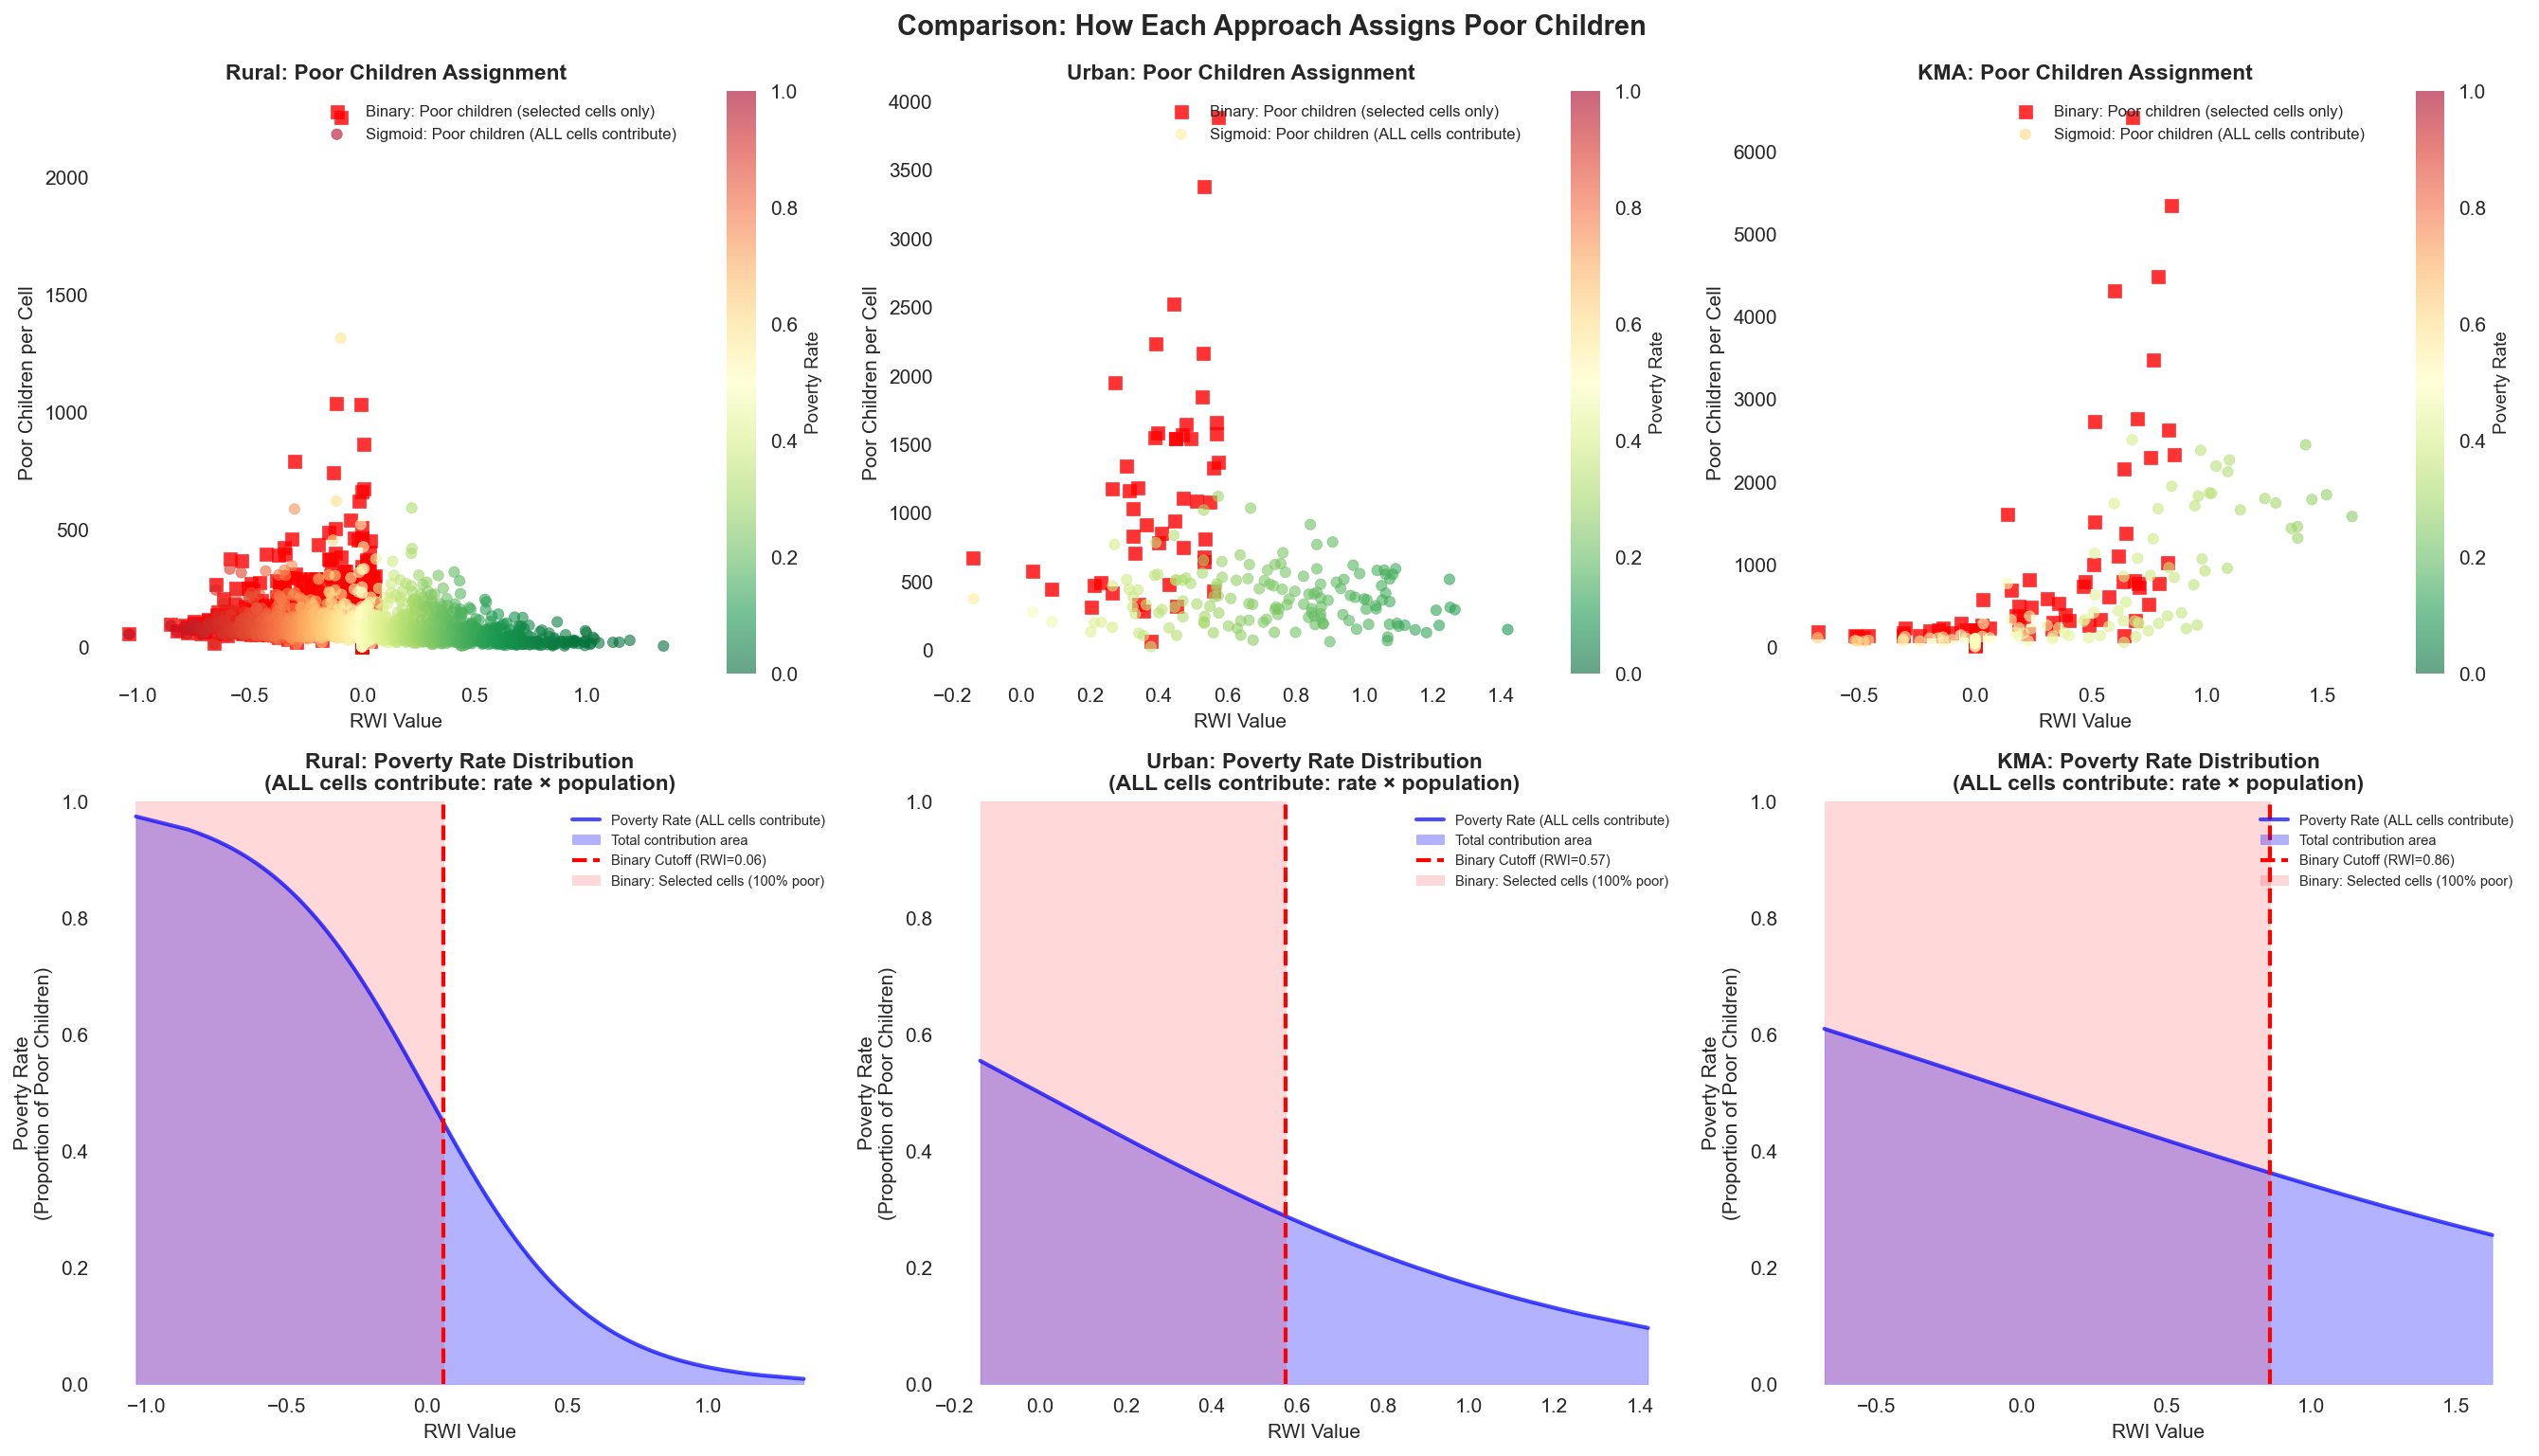


Key Difference:
  Binary: Only selected cells contribute (100% poor in those cells)
  Sigmoid: ALL cells contribute proportionally (poverty_rate × children_population)


In [11]:
# Visual comparison: Show how each approach assigns poor children
# Key difference: Binary selects cells, Sigmoid uses ALL cells proportionally
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, region in enumerate(['Rural', 'Urban', 'KMA']):
    mask = gdf_with_binary['area_classification'] == region
    df_region = gdf_with_binary[mask].copy()
    df_region = df_region.sort_values('rwi')
    
    # Calculate poor children for each approach
    df_region['poor_children_binary'] = df_region['poor_children_binary']
    df_region['poor_children_sigmoid'] = df_region['poverty_prob'] * df_region['children_population']
    
    # Top row: Poor children contribution by RWI
    ax1 = axes[0, idx]
    
    # Binary: Only selected cells contribute
    binary_selected = df_region[df_region['is_poorest_binary']]
    ax1.scatter(binary_selected['rwi'], binary_selected['poor_children_binary'],
                alpha=0.8, s=50, color='red', marker='s', label='Binary: Poor children (selected cells only)')
    
    # Sigmoid: ALL cells contribute proportionally
    # Size by poor children contribution, color by poverty rate
    scatter = ax1.scatter(df_region['rwi'], df_region['poor_children_sigmoid'],
                         c=df_region['poverty_prob'], cmap='RdYlGn_r', 
                         s=30, alpha=0.6, vmin=0, vmax=1,
                         label='Sigmoid: Poor children (ALL cells contribute)')
    
    cbar = plt.colorbar(scatter, ax=ax1)
    cbar.set_label('Poverty Rate', fontsize=9)
    
    ax1.set_xlabel('RWI Value', fontsize=10)
    ax1.set_ylabel('Poor Children per Cell', fontsize=10)
    ax1.set_title(f'{region}: Poor Children Assignment', fontsize=11, fontweight='bold')
    ax1.legend(fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # Bottom row: Poverty rate distribution (showing ALL cells contribute)
    ax2 = axes[1, idx]
    
    # Plot poverty rate curve for ALL cells
    rwi_sorted = df_region['rwi'].values
    prob_sorted = df_region['poverty_prob'].values
    
    ax2.plot(rwi_sorted, prob_sorted, 'b-', linewidth=2, 
            label='Poverty Rate (ALL cells contribute)', alpha=0.7)
    
    # Shade area under curve to show total contribution
    ax2.fill_between(rwi_sorted, 0, prob_sorted, alpha=0.3, color='blue',
                     label='Total contribution area')
    
    # Mark binary cutoff for reference
    if len(binary_selected) > 0:
        binary_max_rwi = binary_selected['rwi'].max()
        ax2.axvline(x=binary_max_rwi, color='r', linestyle='--', linewidth=2, 
                   label=f'Binary Cutoff (RWI={binary_max_rwi:.2f})')
        ax2.axvspan(df_region['rwi'].min(), binary_max_rwi, alpha=0.15, color='red', 
                   label='Binary: Selected cells (100% poor)')
    
    ax2.set_xlabel('RWI Value', fontsize=10)
    ax2.set_ylabel('Poverty Rate\n(Proportion of Poor Children)', fontsize=10)
    ax2.set_title(f'{region}: Poverty Rate Distribution\n(ALL cells contribute: rate × population)', 
                  fontsize=11, fontweight='bold')
    ax2.set_ylim([0, 1])
    ax2.legend(fontsize=7, loc='upper right')
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Comparison: How Each Approach Assigns Poor Children', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

print("\nKey Difference:")
print("  Binary: Only selected cells contribute (100% poor in those cells)")
print("  Sigmoid: ALL cells contribute proportionally (poverty_rate × children_population)")

## ALTERNATIVE: optimize both slope and threshold

In [12]:
# This cell optimizes threshold and slope GLOBALLY (same for all regions)
# using scipy.optimize.least_squares


# 2 unknowns: threshold (global), slope (global)
# 3 constraints: one target per region (Rural, Urban, KMA)
# minimize sum of squares of residuals using least_squares


from scipy.optimize import least_squares

poverty_rate_map = {
    'Rural': POVERTY_RATE_RURAL / 100,
    'Urban': POVERTY_RATE_URBAN / 100,
    'KMA': POVERTY_RATE_KMA / 100
}

region_data_list = []
target_pops = []
region_names = []

for region, rate in poverty_rate_map.items():
    mask = gdf_tiles_with_admin['area_classification'] == region
    df_region = gdf_tiles_with_admin[mask].copy()
    
    if len(df_region) == 0:
        continue
    
    total_pop = df_region['children_population'].sum()
    target_poor = total_pop * rate
    
    region_data_list.append(df_region)
    target_pops.append(target_poor)
    region_names.append(region)



def residuals(params):
    # calculate residuals (errors) for each region.

    threshold, slope = params
    
    # invalid slopes
    if slope <= 0:
        return np.array([1e10] * len(region_data_list))
    
    residuals_list = []
    for df_region, target_pop in zip(region_data_list, target_pops):
        # Get RWI and population values
        rwi_values = df_region['rwi'].values
        pop_values = df_region['children_population'].values
        
        # poverty probabilities using sigmoid
        probs = sigmoid(rwi_values, threshold, slope)
        
        # estimated poor children
        total_estimated = np.sum(probs * pop_values)
        
        # residual
        residual = total_estimated - target_pop
        residuals_list.append(residual)
    
    return np.array(residuals_list)


initial_guess = np.array([0.0, 2.0])
bounds = ([-2.0, 0.01], [2.0, 20.0])  # threshold in [-2, 2], slope in [0.01, 20]

result = least_squares(
    residuals,
    initial_guess,
    bounds=bounds,
    loss='huber', 
    f_scale=1000.0 
)


if result.success or result.status in [1, 2, 3, 4]:
    optimal_threshold, optimal_slope = result.x
    
    # final errors per region
    errors_per_region = residuals(result.x).tolist()
    total_error = sum(abs(e) for e in errors_per_region)
    
    print(f"\n  Global Parameters:")
    print(f"    Threshold: {optimal_threshold:.6f}")
    print(f"    Slope: {optimal_slope:.6f}")
    print(f"    Total absolute error: {total_error:,.2f} poor children")
    print(f"    Cost (sum of squares): {result.cost:,.2f}")
    
    print(f"\n  Errors per region:")
    for region, error in zip(region_names, errors_per_region):
        target_pop = target_pops[region_names.index(region)]
        error_pct = (error / target_pop * 100) if target_pop > 0 else 0
        print(f"    {region:10s}: {error:>12,.2f} ({error_pct:+.2f}%)")
    
    print(f"\n  Verification per region:")
    for region, df_region, target_pop in zip(region_names, region_data_list, target_pops):
        rwi_values = df_region['rwi'].values
        pop_values = df_region['children_population'].values
        probs = sigmoid(rwi_values, optimal_threshold, optimal_slope)
        estimated = np.sum(probs * pop_values)
        error = estimated - target_pop
        error_pct = (error / target_pop * 100) if target_pop > 0 else 0
        print(f"    {region:10s}: Estimated ={estimated:>12,.2f}, Target ={target_pop:>12,.2f}, "
              f"Error ={error:>10,.2f} ({error_pct:+.4f}%)")

    
    GLOBAL_THRESHOLD = optimal_threshold
    GLOBAL_SLOPE = optimal_slope
    
    gdf_results_global = gdf_tiles_with_admin.copy()
    gdf_results_global['poverty_prob_global'] = sigmoid(
        gdf_results_global['rwi'], 
        optimal_threshold, 
        optimal_slope
    )
    gdf_results_global['poor_children_global'] = (
        gdf_results_global['poverty_prob_global'] * 
        gdf_results_global['children_population']
    )
    
else:
    print("\nOptimization failed!")
    print(f"   Status: {result.status}")
    print(f"   Message: {result.message}")


  Global Parameters:
    Threshold: -0.411380
    Slope: 1.002753
    Total absolute error: 27,191.37 poor children
    Cost (sum of squares): 26,123,531.37

  Errors per region:
    Rural     :       -83.50 (-0.06%)
    Urban     :       843.97 (+1.48%)
    KMA       :   -26,263.90 (-40.87%)

  Verification per region:
    Rural     : Estimated =  142,488.43, Target =  142,571.93, Error =    -83.50 (-0.0586%)
    Urban     : Estimated =   57,773.14, Target =   56,929.17, Error =    843.97 (+1.4825%)
    KMA       : Estimated =   37,991.97, Target =   64,255.87, Error =-26,263.90 (-40.8739%)



COMPARISON BY REGION

Region           Target   Binary Est   Binary Err  Sigmoid Est  Sigmoid Err   Global Est   Global Err
------------------------------------------------------------------------------------------------------------------------
Rural           142,572      142,839          267      142,572           -0      142,488          -83
Urban            56,929       57,165          236       56,929           -0       57,773          844
KMA              64,256       65,004          748       64,256            0       37,992      -26,264

ERROR PERCENTAGES BY REGION

Region      Binary Error %    Sigmoid Error %  Global Error %
------------------------------------------------------------
Rural                0.19%             -0.00%          -0.06%
Urban                0.41%             -0.00%           1.48%
KMA                  1.16%              0.00%         -40.87%

Total Absolute Error:
  Binary approach:      1,251.26 poor children
  Sigmoid (individual):         0.00 po

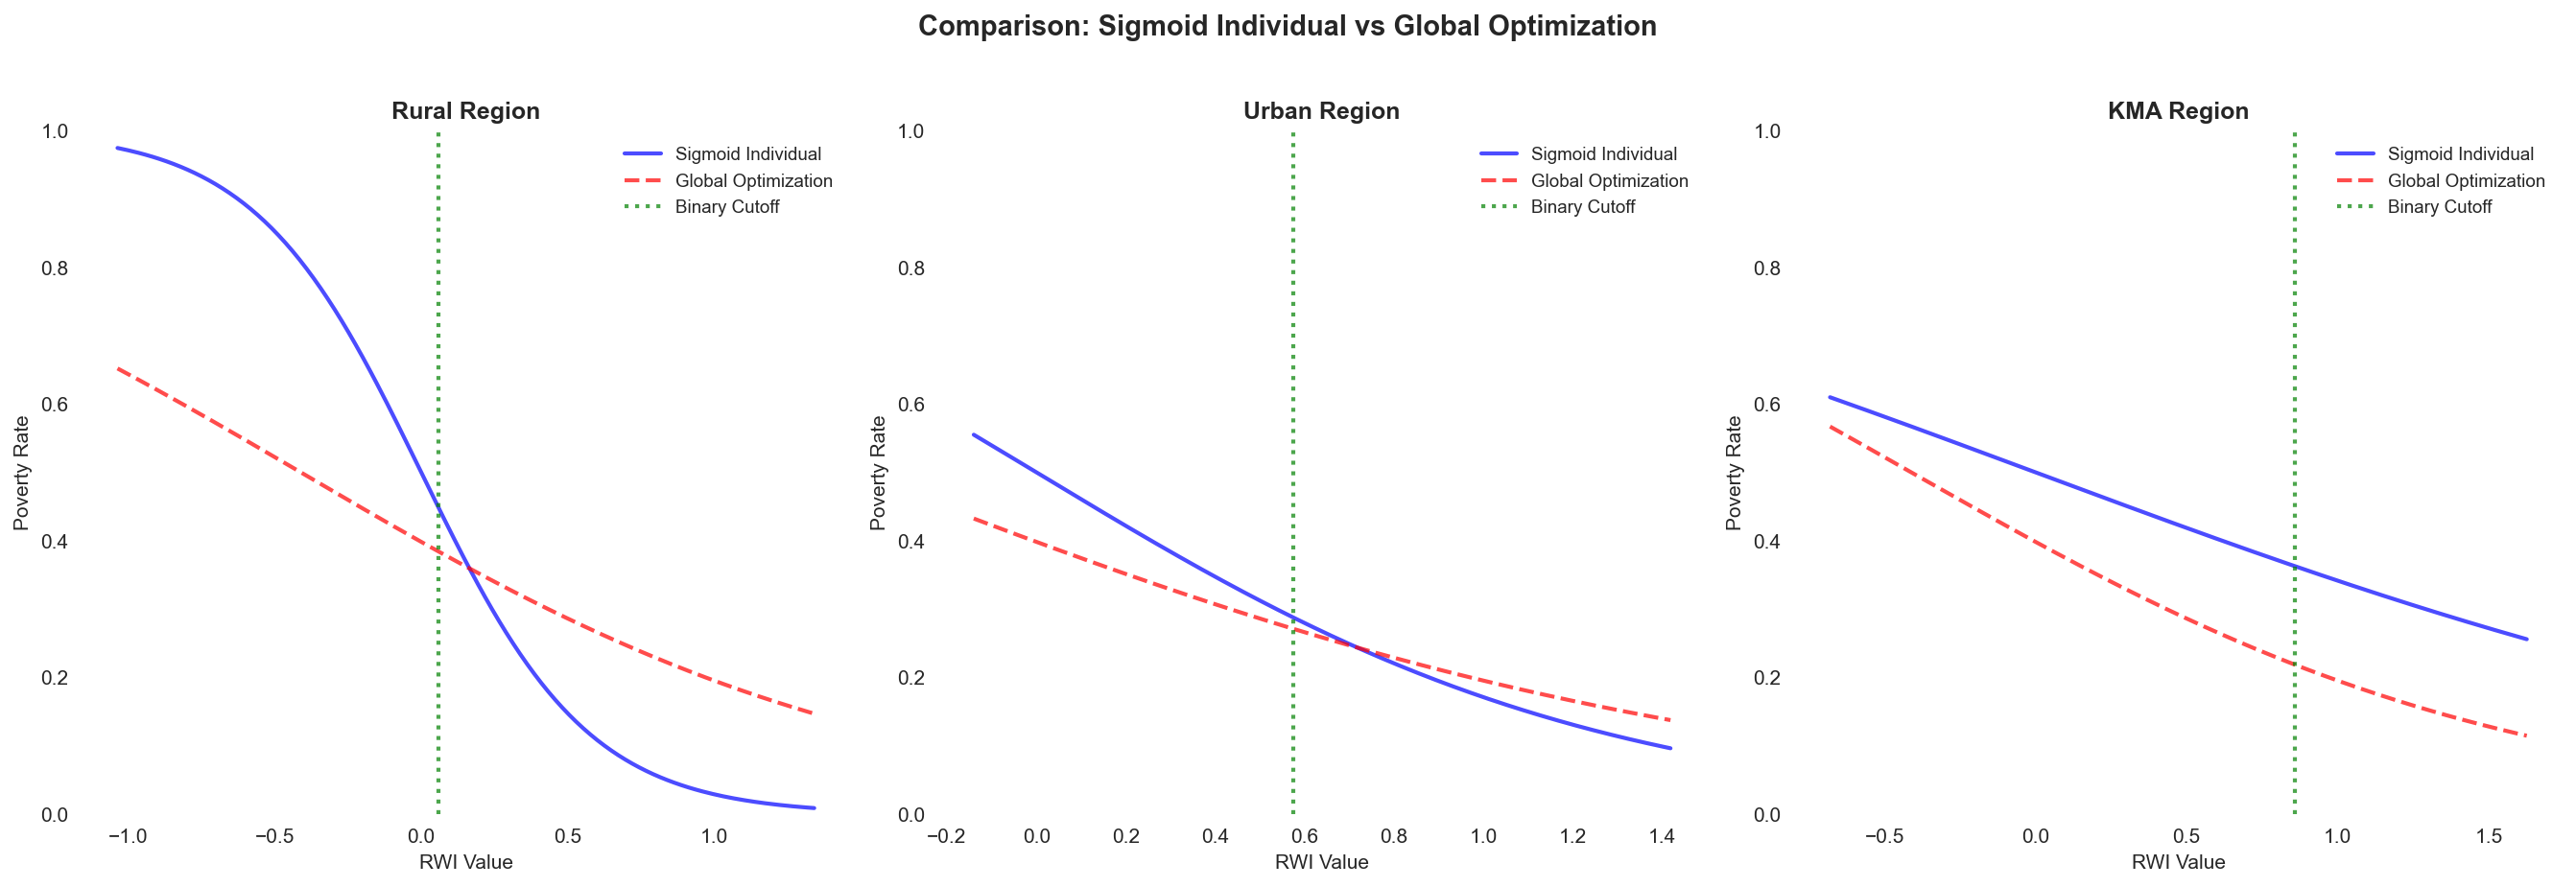

In [13]:
# calculate summary statistics for each approach
comparison_summary = []

poverty_rate_map = {
    'Rural': POVERTY_RATE_RURAL / 100,
    'Urban': POVERTY_RATE_URBAN / 100,
    'KMA': POVERTY_RATE_KMA / 100
}

for region in ['Rural', 'Urban', 'KMA']:
    mask = gdf_tiles_with_admin['area_classification'] == region
    df_region = gdf_tiles_with_admin[mask].copy()
    
    # target
    total_pop = df_region['children_population'].sum()
    target_poor = total_pop * poverty_rate_map[region]
    
    # 1. binary approach
    binary_poor = gdf_with_binary.loc[mask, 'poor_children_binary'].sum()
    binary_error = binary_poor - target_poor
    
    # 2. sigmoid individual (per region optimization)
    sigmoid_poor = (gdf_results.loc[mask, 'poverty_prob'] *
    gdf_results.loc[mask, 'children_population']).sum()
    sigmoid_error = sigmoid_poor - target_poor
    
    # 3. global optimization
    global_poor = gdf_results_global.loc[mask, 'poor_children_global'].sum()
    global_error = global_poor - target_poor
    
    comparison_summary.append({
        'Region': region,
        'Target': target_poor,
        'Binary_Estimated': binary_poor,
        'Binary_Error': binary_error,
        'Binary_Error_Pct': (binary_error / target_poor * 100) if target_poor > 0 else 0,
        'Sigmoid_Estimated': sigmoid_poor,
        'Sigmoid_Error': sigmoid_error,
        'Sigmoid_Error_Pct': (sigmoid_error / target_poor * 100) if target_poor > 0 else 0,
        'Global_Estimated': global_poor,
        'Global_Error': global_error,
        'Global_Error_Pct': (global_error / target_poor * 100) if target_poor > 0 else 0,
    })

df_comparison = pd.DataFrame(comparison_summary)


print("\n" + "="*120)
print("COMPARISON BY REGION")
print("="*120)
print(f"\n{'Region':<10} {'Target':>12} {'Binary Est':>12} {'Binary Err':>12} {'Sigmoid Est':>12} {'Sigmoid Err':>12} {'Global Est':>12} {'Global Err':>12}")
print("-"*120)
for _, row in df_comparison.iterrows():
    print(f"{row['Region']:<10} {row['Target']:>12,.0f} {row['Binary_Estimated']:>12,.0f} "
          f"{row['Binary_Error']:>12,.0f} {row['Sigmoid_Estimated']:>12,.0f} "
          f"{row['Sigmoid_Error']:>12,.0f} {row['Global_Estimated']:>12,.0f} "
          f"{row['Global_Error']:>12,.0f}")

print("\n" + "="*120)
print("ERROR PERCENTAGES BY REGION")
print("="*120)
print(f"\n{'Region':<10} {'Binary Error %':>15} {'Sigmoid Error %':>18} {'Global Error %':>15}")
print("-"*60)
for _, row in df_comparison.iterrows():
    print(f"{row['Region']:<10} {row['Binary_Error_Pct']:>14.2f}% {row['Sigmoid_Error_Pct']:>17.2f}% "
          f"{row['Global_Error_Pct']:>14.2f}%")



total_binary_error = df_comparison['Binary_Error'].abs().sum()
total_sigmoid_error = df_comparison['Sigmoid_Error'].abs().sum()
total_global_error = df_comparison['Global_Error'].abs().sum()

max_binary_error = df_comparison['Binary_Error'].abs().max()
max_sigmoid_error = df_comparison['Sigmoid_Error'].abs().max()
max_global_error = df_comparison['Global_Error'].abs().max()

print(f"\nTotal Absolute Error:")
print(f"  Binary approach:  {total_binary_error:>12,.2f} poor children")
print(f"  Sigmoid (individual): {total_sigmoid_error:>12,.2f} poor children")
print(f"  Global optimization:  {total_global_error:>12,.2f} poor children")

print(f"\nMaximum Absolute Error (worst region):")
print(f"  Binary approach:  {max_binary_error:>12,.2f} poor children")
print(f"  Sigmoid (individual): {max_sigmoid_error:>12,.2f} poor children")
print(f"  Global optimization:  {max_global_error:>12,.2f} poor children")

# parameter comparison
print("\n" + "="*120)
print("PARAMETER COMPARISON")
print("="*120)
print("\nSigmoid Individual Approach (per region):")
if 'df_stats' in locals():
    print(df_stats[['Region', 'Optimal_Slope']].to_string(index=False))
    print("\nNote: Threshold fixed at 0.0 for all regions")

print("\nGlobal Optimization Approach:")
print(f"  Threshold: {GLOBAL_THRESHOLD:.6f} (same for all regions)")
print(f"  Slope: {GLOBAL_SLOPE:.6f} (same for all regions)")

# Visualization comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, region in enumerate(['Rural', 'Urban', 'KMA']):
    ax = axes[idx]
    mask = gdf_tiles_with_admin['area_classification'] == region
    df_region = gdf_tiles_with_admin[mask].copy()
    df_region = df_region.sort_values('rwi')
    
    # Plot sigmoid curves
    rwi_range = np.linspace(df_region['rwi'].min(), df_region['rwi'].max(), 200)
    
    # Individual sigmoid (per region)
    region_stats = df_stats[df_stats['Region'] == region]
    sigmoid_slope = region_stats['Optimal_Slope'].iloc[0]
    
    sigmoid_thresh = 0.0  # Fixed threshold
    
    probs_individual = sigmoid(rwi_range, sigmoid_thresh, sigmoid_slope)
    probs_global = sigmoid(rwi_range, GLOBAL_THRESHOLD, GLOBAL_SLOPE)
    
    ax.plot(rwi_range, probs_individual, 'b-', linewidth=2, label='Sigmoid Individual', alpha=0.7)
    ax.plot(rwi_range, probs_global, 'r--', linewidth=2, label='Global Optimization', alpha=0.7)
    
    # binary cutoff 
    binary_region = gdf_with_binary[gdf_with_binary['area_classification'] == region]
    binary_max_rwi = binary_region[binary_region['is_poorest_binary']]['rwi'].max()
    ax.axvline(x=binary_max_rwi, color='g', linestyle=':', linewidth=2, label='Binary Cutoff', alpha=0.7)
    
    ax.set_xlabel('RWI Value', fontsize=10)
    ax.set_ylabel('Poverty Rate', fontsize=10)
    ax.set_title(f'{region} Region', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1])

plt.suptitle('Comparison: Sigmoid Individual vs Global Optimization', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Map Comparisons

  Saved: analysis_output/visualizations/spatial_distribution_comparison_where_are_poor_children_located.png


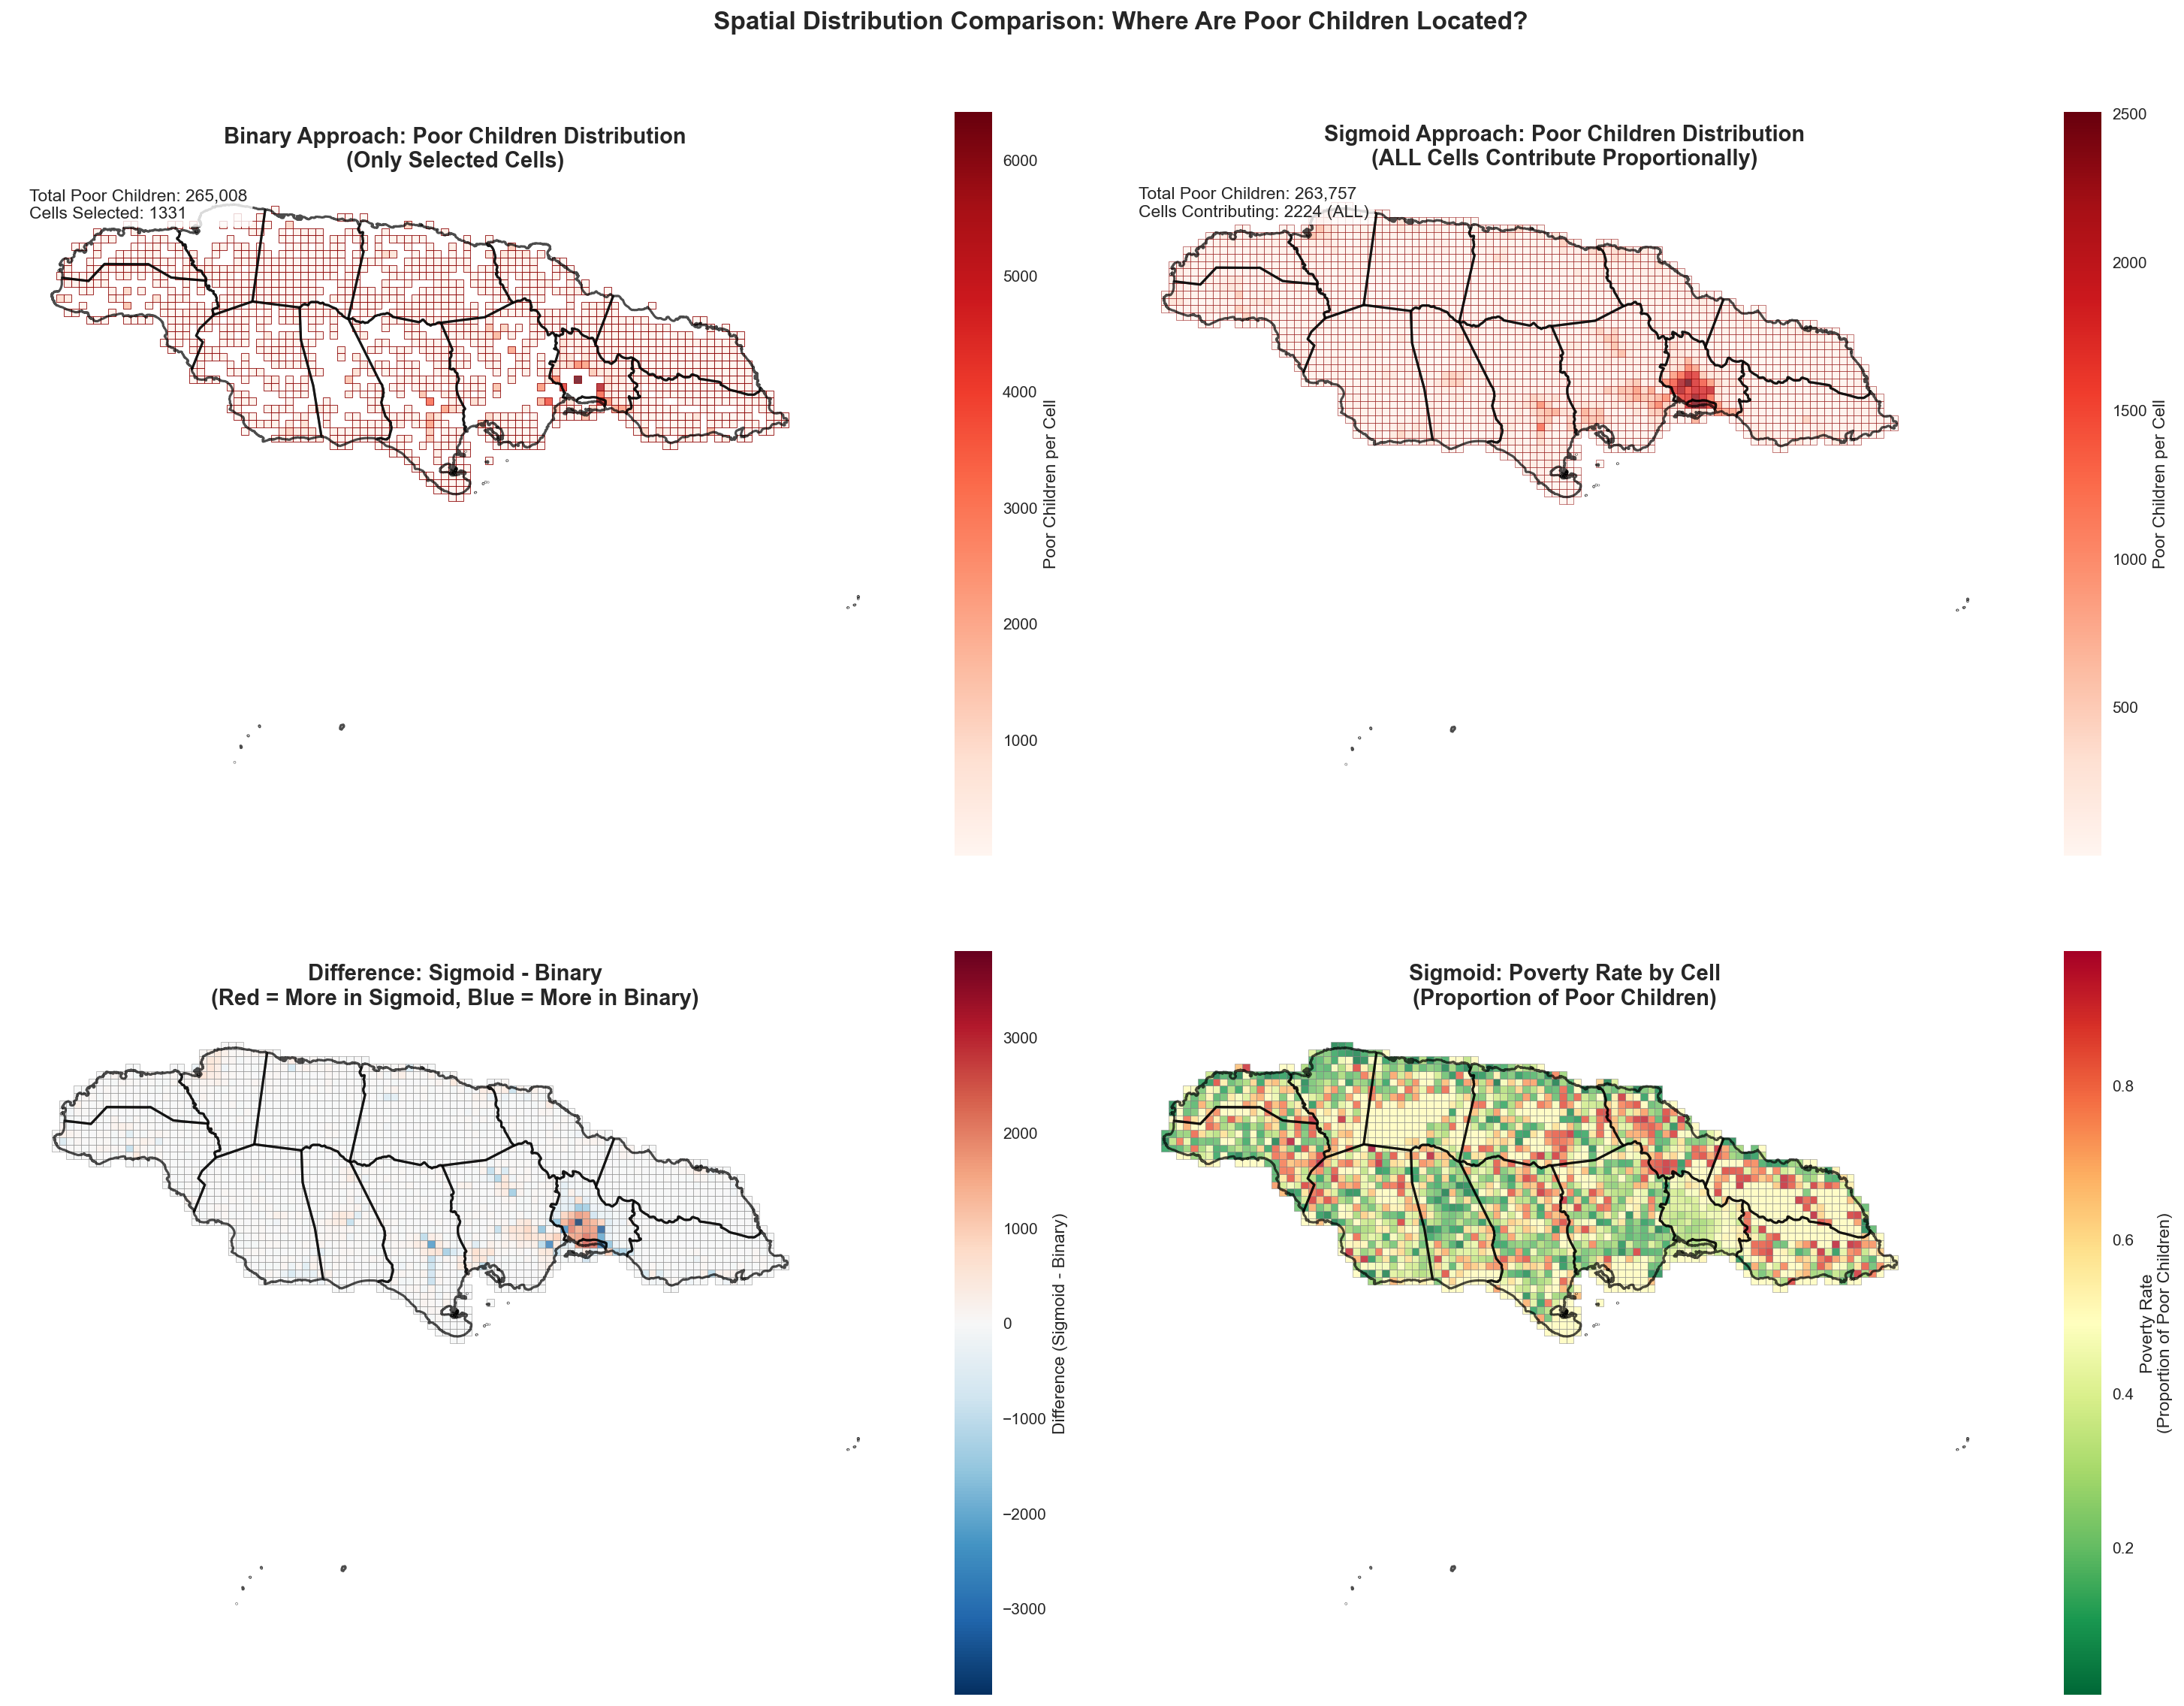


Binary Approach:
  - Cells with poor children: 1331 (selected cells only)
  - Total poor children: 265,008
  - Pattern: Concentrated in selected cells (hard boundaries)

Sigmoid Approach:
  - Cells contributing: 2224 (ALL cells)
  - Total poor children: 263,757
  - Pattern: Distributed across all cells proportionally (smooth gradient)


In [14]:
# Calculate poor children for both approaches
gdf_with_binary['poor_children_sigmoid'] = (
    gdf_with_binary['poverty_prob'] * gdf_with_binary['children_population']
)

# Create side-by-side map comparison
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Get admin boundaries for context
gdf_admin_plot = gdf_admin.copy()

# 1. Binary Approach: Poor Children Map
ax1 = axes[0, 0]
gdf_with_binary_binary = gdf_with_binary[gdf_with_binary['is_poorest_binary']].copy()
gdf_with_binary_binary.plot(
    column='poor_children_binary',
    cmap='Reds',
    legend=True,
    legend_kwds={'label': 'Poor Children per Cell', 'shrink': 0.8},
    ax=ax1,
    alpha=0.8,
    edgecolor='darkred',
    linewidth=0.5
)
gdf_admin_plot.plot(ax=ax1, facecolor='none', edgecolor='black', lw=1.5, alpha=0.7)
ax1.set_title('Binary Approach: Poor Children Distribution\n(Only Selected Cells)', 
              fontsize=14, fontweight='bold')
ax1.axis('off')

# Add summary text
total_binary = gdf_with_binary_binary['poor_children_binary'].sum()
cells_binary = len(gdf_with_binary_binary)
ax1.text(0.02, 0.98, 
         f'Total Poor Children: {total_binary:,.0f}\nCells Selected: {cells_binary}',
         transform=ax1.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Sigmoid Approach: Poor Children Map (ALL cells contribute)
ax2 = axes[0, 1]
gdf_with_binary.plot(
    column='poor_children_sigmoid',
    cmap='Reds',
    legend=True,
    legend_kwds={'label': 'Poor Children per Cell', 'shrink': 0.8},
    ax=ax2,
    alpha=0.8,
    edgecolor='darkred',
    linewidth=0.3
)
gdf_admin_plot.plot(ax=ax2, facecolor='none', edgecolor='black', lw=1.5, alpha=0.7)
ax2.set_title('Sigmoid Approach: Poor Children Distribution\n(ALL Cells Contribute Proportionally)', 
              fontsize=14, fontweight='bold')
ax2.axis('off')

# Add summary text
total_sigmoid = gdf_with_binary['poor_children_sigmoid'].sum()
cells_sigmoid = len(gdf_with_binary)
ax2.text(0.02, 0.98, 
         f'Total Poor Children: {total_sigmoid:,.0f}\nCells Contributing: {cells_sigmoid} (ALL)',
         transform=ax2.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 3. Difference Map: Show where approaches differ
ax3 = axes[1, 0]
gdf_with_binary['poor_children_diff'] = (
    gdf_with_binary['poor_children_sigmoid'] - gdf_with_binary['poor_children_binary']
)
gdf_with_binary.plot(
    column='poor_children_diff',
    cmap='RdBu_r',
    legend=True,
    legend_kwds={'label': 'Difference (Sigmoid - Binary)', 'shrink': 0.8},
    ax=ax3,
    alpha=0.8,
    edgecolor='gray',
    linewidth=0.3,
    vmin=-gdf_with_binary['poor_children_diff'].abs().max(),
    vmax=gdf_with_binary['poor_children_diff'].abs().max()
)
gdf_admin_plot.plot(ax=ax3, facecolor='none', edgecolor='black', lw=1.5, alpha=0.7)
ax3.set_title('Difference: Sigmoid - Binary\n(Red = More in Sigmoid, Blue = More in Binary)', 
              fontsize=14, fontweight='bold')
ax3.axis('off')

# 4. Poverty Rate Map (Sigmoid)
ax4 = axes[1, 1]
gdf_with_binary.plot(
    column='poverty_prob',
    cmap='RdYlGn_r',
    legend=True,
    legend_kwds={'label': 'Poverty Rate\n(Proportion of Poor Children)', 'shrink': 0.8},
    ax=ax4,
    alpha=0.8,
    edgecolor='gray',
    linewidth=0.3
)
gdf_admin_plot.plot(ax=ax4, facecolor='none', edgecolor='black', lw=1.5, alpha=0.7)
ax4.set_title('Sigmoid: Poverty Rate by Cell\n(Proportion of Poor Children)', 
              fontsize=14, fontweight='bold')
ax4.axis('off')

plt.tight_layout()
plt.suptitle('Spatial Distribution Comparison: Where Are Poor Children Located?', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()


print(f"\nBinary Approach:")
print(f"  - Cells with poor children: {cells_binary} (selected cells only)")
print(f"  - Total poor children: {total_binary:,.0f}")
print(f"  - Pattern: Concentrated in selected cells (hard boundaries)")
print(f"\nSigmoid Approach:")
print(f"  - Cells contributing: {cells_sigmoid} (ALL cells)")
print(f"  - Total poor children: {total_sigmoid:,.0f}")
print(f"  - Pattern: Distributed across all cells proportionally (smooth gradient)")

### Parish-level aggregation comparision

  Saved: analysis_output/visualizations/parish-level_comparison_spatial_distribution_of_poor_children.png


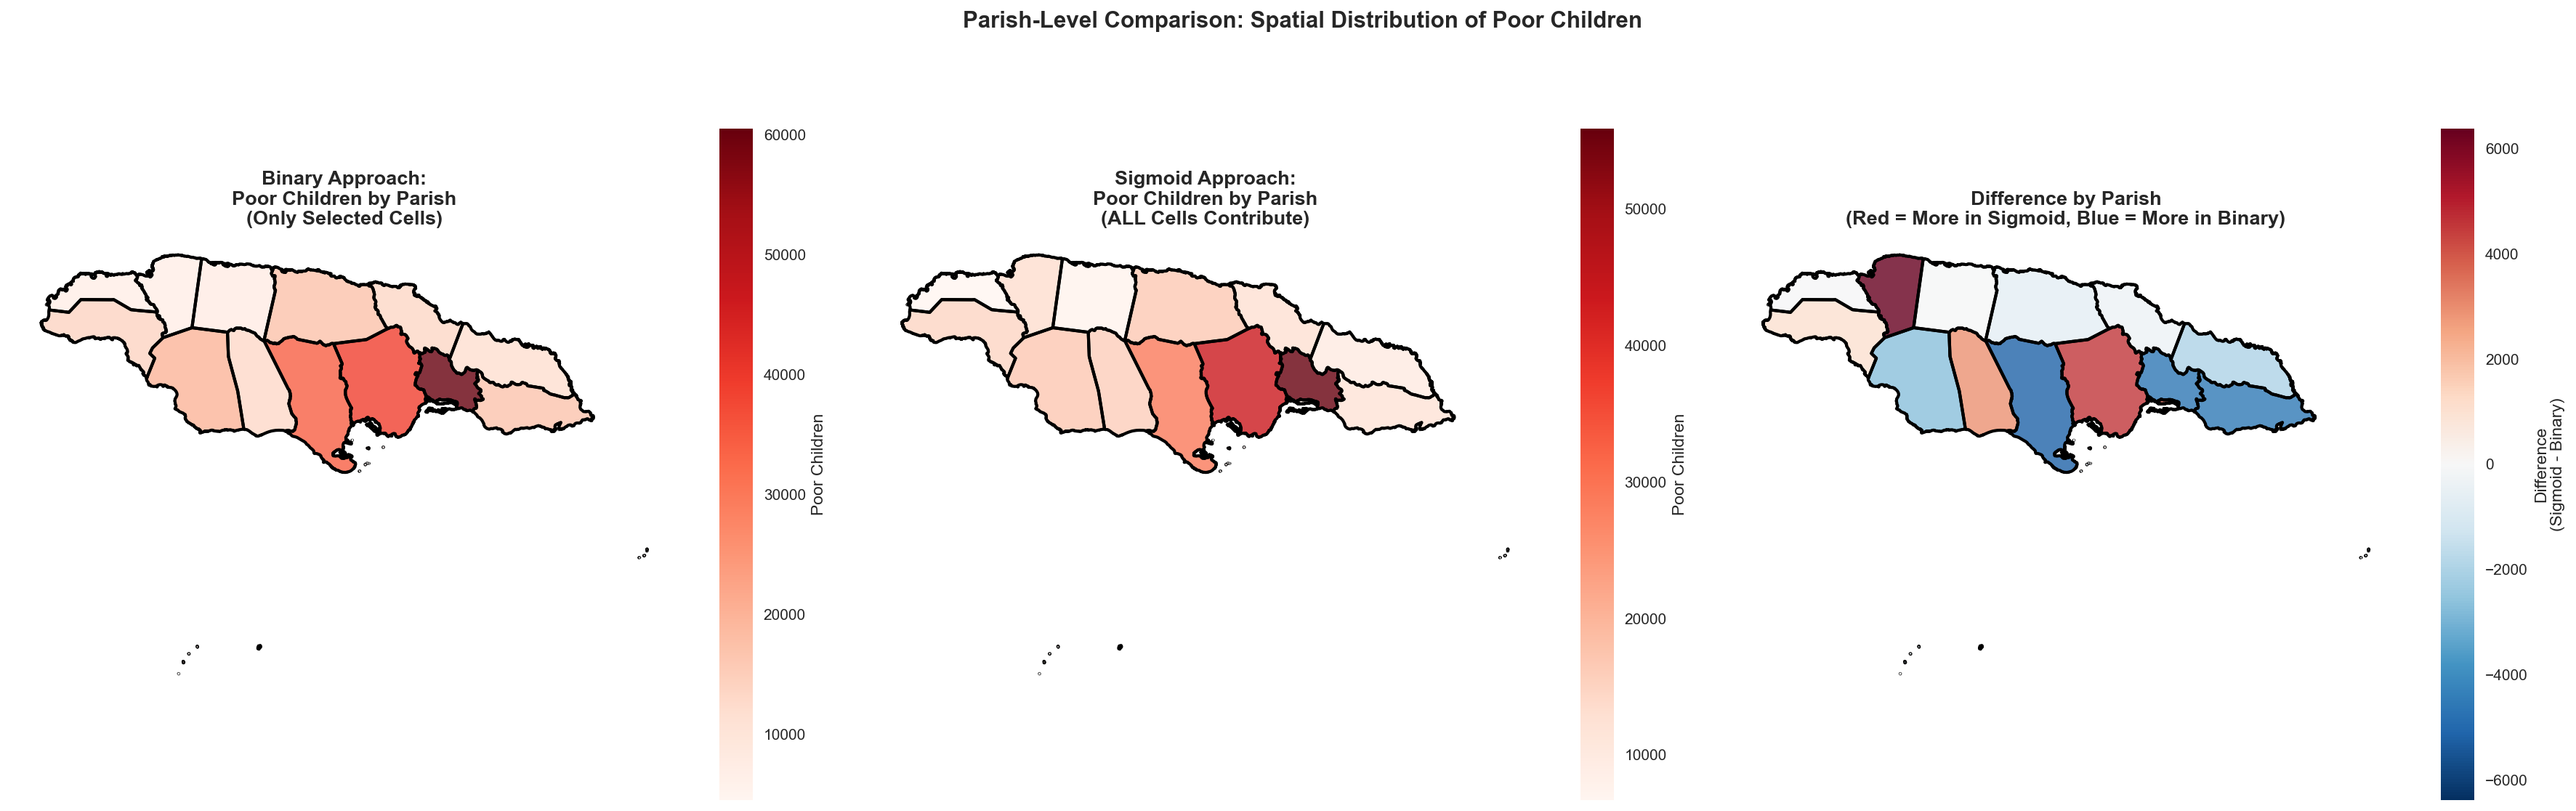

         parish  poor_children_binary  poor_children_sigmoid         diff
   Saint Andrew          60522.715248           55897.630669 -4625.084579
Saint Catherine          38926.638267           43497.381581  4570.743314
      Clarendon          34125.970062           28941.821975 -5184.148087
Saint Elizabeth          19727.352165           17071.708798 -2655.643367
      Saint Ann          17372.398459           16753.153237  -619.245222
     Manchester          13005.771297           15900.989844  2895.218548
   Westmoreland          13723.579457           14746.265435  1022.685978
    Saint James           7001.641774           13383.074042  6381.432268
     Saint Mary          13343.516888           13008.995542  -334.521346
   Saint Thomas          16745.502899           12230.614011 -4514.888887
       Portland          11829.746719            9852.263767 -1977.482952
       Kingston           4481.383774            8358.242342  3876.858569
       Trelawny           7418.888927 

In [15]:
# Aggregate by parish for both approaches
parish_binary = gdf_with_binary[gdf_with_binary['is_poorest_binary']].groupby('parish').agg({
    'poor_children_binary': 'sum',
    'children_population': 'sum'
}).reset_index()
parish_binary.columns = ['parish', 'poor_children_binary', 'children_population_binary']

parish_sigmoid = gdf_with_binary.groupby('parish').agg({
    'poor_children_sigmoid': 'sum',
    'children_population': 'sum'
}).reset_index()
parish_sigmoid.columns = ['parish', 'poor_children_sigmoid', 'children_population_sigmoid']

parish_comparison = parish_binary.merge(parish_sigmoid, on='parish', how='outer').fillna(0)
parish_comparison['diff'] = parish_comparison['poor_children_sigmoid'] - parish_comparison['poor_children_binary']

# Create comparison map by parish
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Merge with admin boundaries for mapping
parish_map_binary = gdf_admin.merge(parish_binary, left_on='name', right_on='parish', how='left')
parish_map_sigmoid = gdf_admin.merge(parish_sigmoid, left_on='name', right_on='parish', how='left')
parish_map_diff = gdf_admin.merge(parish_comparison, left_on='name', right_on='parish', how='left')

# 1. Binary: Poor children by parish
ax1 = axes[0]
parish_map_binary.plot(
    column='poor_children_binary',
    cmap='Reds',
    legend=True,
    legend_kwds={'label': 'Poor Children', 'shrink': 0.8},
    ax=ax1,
    alpha=0.8,
    edgecolor='black',
    linewidth=1.5
)
parish_map_binary.plot(ax=ax1, facecolor='none', edgecolor='black', lw=2, alpha=1)
ax1.set_title('Binary Approach:\nPoor Children by Parish\n(Only Selected Cells)', 
              fontsize=13, fontweight='bold')
ax1.axis('off')

# 2. Sigmoid: Poor children by parish
ax2 = axes[1]
parish_map_sigmoid.plot(
    column='poor_children_sigmoid',
    cmap='Reds',
    legend=True,
    legend_kwds={'label': 'Poor Children', 'shrink': 0.8},
    ax=ax2,
    alpha=0.8,
    edgecolor='black',
    linewidth=1.5
)
parish_map_sigmoid.plot(ax=ax2, facecolor='none', edgecolor='black', lw=2, alpha=1)
ax2.set_title('Sigmoid Approach:\nPoor Children by Parish\n(ALL Cells Contribute)', 
              fontsize=13, fontweight='bold')
ax2.axis('off')

# 3. Difference
ax3 = axes[2]
parish_map_diff.plot(
    column='diff',
    cmap='RdBu_r',
    legend=True,
    legend_kwds={'label': 'Difference\n(Sigmoid - Binary)', 'shrink': 0.8},
    ax=ax3,
    alpha=0.8,
    edgecolor='black',
    linewidth=1.5,
    vmin=-parish_map_diff['diff'].abs().max(),
    vmax=parish_map_diff['diff'].abs().max()
)
parish_map_diff.plot(ax=ax3, facecolor='none', edgecolor='black', lw=2, alpha=1)
ax3.set_title('Difference by Parish\n(Red = More in Sigmoid, Blue = More in Binary)', 
              fontsize=13, fontweight='bold')
ax3.axis('off')

plt.tight_layout()
plt.suptitle('Parish-Level Comparison: Spatial Distribution of Poor Children', 
             fontsize=15, fontweight='bold', y=1.02)
plt.show()

# Print parish-level comparison table
print("="*100)
parish_comparison_sorted = parish_comparison.sort_values('poor_children_sigmoid', ascending=False)
print(parish_comparison_sorted[['parish', 'poor_children_binary', 'poor_children_sigmoid', 'diff']].to_string(index=False))

## Poor children distribution map

  Saved: analysis_output/visualizations/sigmoid_approach_poor_children_distribution_poor_children__poverty_rate__children_population.png


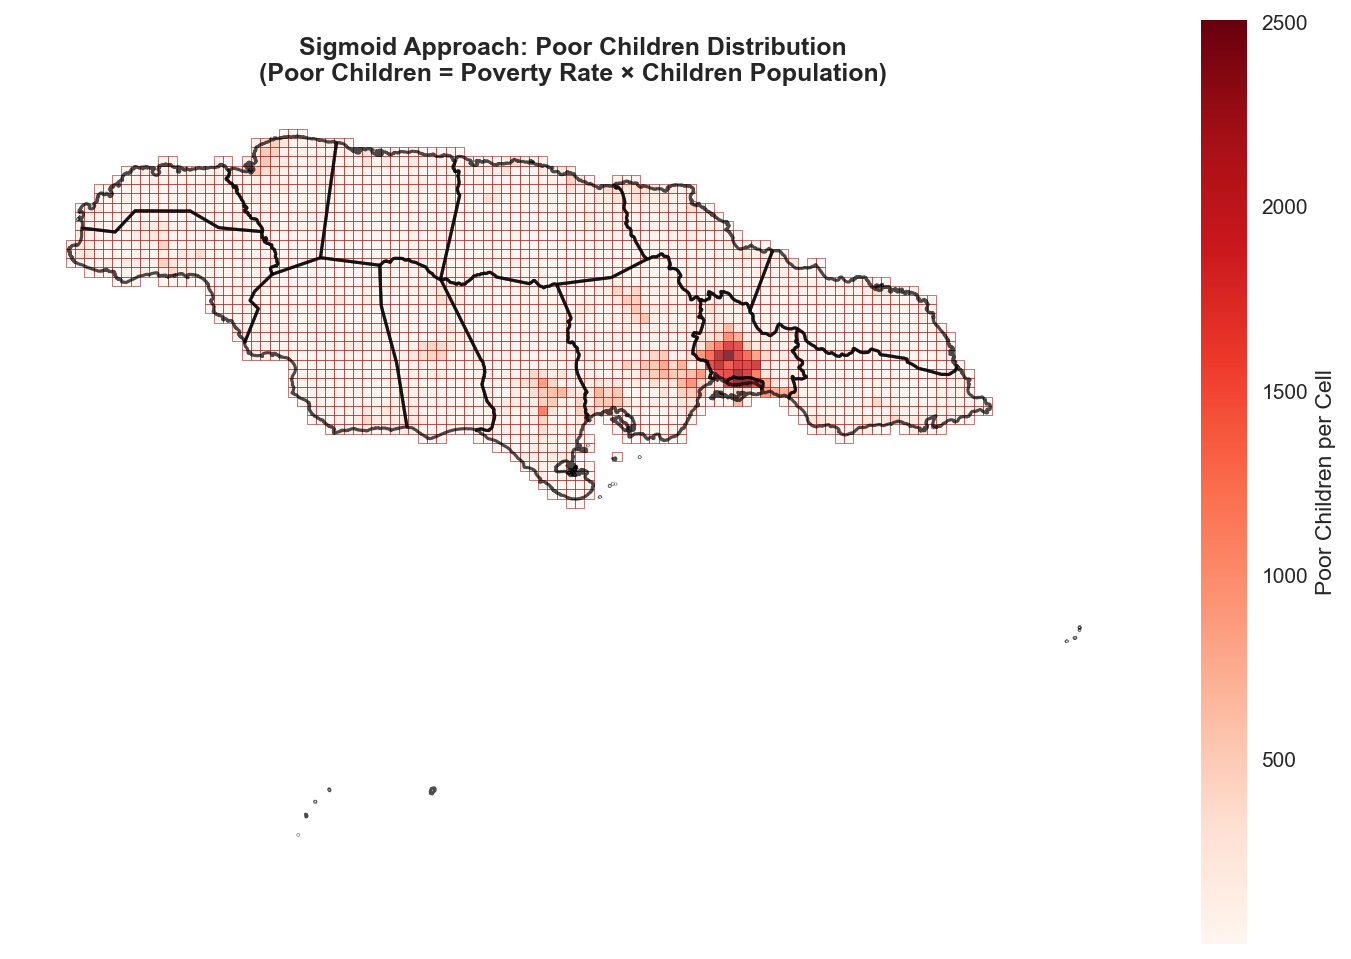

In [16]:
# Calculate poor children for each cell: poverty_rate x children_population
gdf_results['poor_children'] = gdf_results['poverty_prob'] * gdf_results['children_population']

# Create map showing number of poor children per cell
fig, ax = plt.subplots(figsize=(12, 10))

gdf_results.plot(
    column='poor_children',
    cmap='Reds',  # Red = More Poor Children
    legend=True,
    legend_kwds={'label': 'Poor Children per Cell', 'shrink': 0.8},
    ax=ax,
    alpha=0.8,
    edgecolor='darkred',
    linewidth=0.3
)

gdf_admin.plot(ax=ax, facecolor='none', edgecolor='black', lw=1.5, alpha=0.7)
ax.set_title("Sigmoid Approach: Poor Children Distribution\n(Poor Children = Poverty Rate × Children Population)", 
             fontsize=12, fontweight='bold')
ax.axis('off')

# Add summary statistics
total_poor = gdf_results['poor_children'].sum()
total_cells = len(gdf_results)
cells_with_poor = (gdf_results['poor_children'] > 0).sum()

plt.show()

## Calculate Expected Impacted Poor Children


In [17]:
# Store impact data for multiple thresholds (tile-level only)
impact_tile_data = {}

if DATE and FORECAST_TIME and WIND_THRESHOLDS and STORM:
    date_str = DATE.replace("-", "")
    forecast_datetime_str = f"{date_str}{FORECAST_TIME}"
    
    # Load tile-level data for each wind threshold
    for wind_threshold in WIND_THRESHOLDS:
        tile_impact_file = f"{COUNTRY}_{STORM}_{forecast_datetime_str}_{wind_threshold}_14.csv"
        tile_impact_path = os.path.join(BASE_DIR, "geodb", "aos_views", "mercator_views", tile_impact_file)
        
        if os.path.exists(tile_impact_path):
            print(f"Loading tile-level impact data for {wind_threshold}kt from: {tile_impact_path}")
            df_tile = pd.read_csv(tile_impact_path)
            zone_cols = [col for col in ['zone_id', 'tile_id', 'tileid', 'tile'] if col in df_tile.columns]
            if not zone_cols or 'probability' not in df_tile.columns:
                print(f"  Tile file missing required columns; {wind_threshold}kt will have 0 impact")
                continue
            zone_col = zone_cols[0]
            impact_tile_data[wind_threshold] = df_tile[[zone_col, 'probability']].rename(columns={zone_col: 'tile_id_source'})
            print(f"  Loaded {len(df_tile)} tile probabilities")
        else:
            print(f"Tile-level impact file not found for {wind_threshold}kt: {tile_impact_path}")
            print(f"  {wind_threshold}kt will have 0 impact (no data available)")
    
    # Process all requested thresholds (even if no data, set impact to 0)
    if WIND_THRESHOLDS:
        # Ensure we have poor_children calculated
        if 'poor_children' not in gdf_results.columns:
            gdf_results['poor_children'] = gdf_results['poverty_prob'] * gdf_results['children_population']
        
        # Attach a helper column for tile-id matching (strip leading zeros for consistency)
        gdf_results['tile_id_match'] = gdf_results['tile_id'].astype(str).str.lstrip('0')
        
        # Merge tile-level probabilities for thresholds with data
        if impact_tile_data:
            print(f"\nMerging tile-level impact probabilities for {len(impact_tile_data)} threshold(s)...")
            for wind_threshold, df_tile in impact_tile_data.items():
                prob_col = f'impact_probability_{wind_threshold}kt'
                impact_col = f'potentially_impacted_poor_children_{wind_threshold}kt'
                df_tile = df_tile.copy()
                df_tile['tile_id_match'] = df_tile['tile_id_source'].astype(str).str.lstrip('0')
                df_tile = df_tile.rename(columns={'probability': prob_col})
                gdf_results = gdf_results.merge(
                    df_tile[['tile_id_match', prob_col]],
                    on='tile_id_match',
                    how='left'
                )
                # Calculate expected impacted poor children at TILE LEVEL using sigmoid approach:
                # Impact = Poor Children x Impact Probability
                # Where Poor Children = poverty_prob × children_population (already calculated)
                # ALL cells contribute proportionally based on their poverty rate
                gdf_results[impact_col] = (
                    gdf_results['poor_children'] * gdf_results[prob_col]
                ).fillna(0).round(0).astype(int)
        
        # For thresholds without data, set impact to 0
        for wind_threshold in WIND_THRESHOLDS:
            impact_col = f'potentially_impacted_poor_children_{wind_threshold}kt'
            if impact_col not in gdf_results.columns:
                # No data available for this threshold, set impact to 0
                gdf_results[impact_col] = 0
        
        # Aggregate impact data by classification for summary
        impact_summary = []
        for classification in ['KMA', 'Urban', 'Rural']:
            classification_tiles = gdf_results[gdf_results['area_classification'] == classification]
            
            if len(classification_tiles) > 0:
                row = {
                    'classification': classification,
                    'total_poor_children': classification_tiles['poor_children'].sum()
                }
                for wind_threshold in WIND_THRESHOLDS:
                    impact_col = f'potentially_impacted_poor_children_{wind_threshold}kt'
                    row[impact_col] = classification_tiles[impact_col].sum()
                impact_summary.append(row)
        
        # Report totals for each threshold
        print(f"\nImpact probability processing complete for {len(WIND_THRESHOLDS)} threshold(s)")
        for wind_threshold in WIND_THRESHOLDS:
            impact_col = f'potentially_impacted_poor_children_{wind_threshold}kt'
            if impact_col in gdf_results.columns:
                total = gdf_results[impact_col].sum()
                if total > 0:
                    print(f"   {wind_threshold}kt: Total potentially impacted poor children: {total:,.0f}")
                else:
                    print(f"   {wind_threshold}kt: Total potentially impacted poor children: 0 (no data available)")
else:
    print("Impact probability configuration not set (DATE, FORECAST_TIME, WIND_THRESHOLDS, STORM)")
    print("   Skipping impact probability calculation")


Loading tile-level impact data for 34kt from: data/geodb/aos_views/mercator_views/JAM_MELISSA_20251027000000_34_14.csv
  Loaded 2231 tile probabilities
Loading tile-level impact data for 50kt from: data/geodb/aos_views/mercator_views/JAM_MELISSA_20251027000000_50_14.csv
  Loaded 2231 tile probabilities
Loading tile-level impact data for 64kt from: data/geodb/aos_views/mercator_views/JAM_MELISSA_20251027000000_64_14.csv
  Loaded 2231 tile probabilities

Merging tile-level impact probabilities for 3 threshold(s)...

Impact probability processing complete for 3 threshold(s)
   34kt: Total potentially impacted poor children: 88,432
   50kt: Total potentially impacted poor children: 8,752
   64kt: Total potentially impacted poor children: 1,977


## Expected Impacted Poor Children by Parish



Parish Impact Summary:
         parish  total_tiles  poor_children
      Clarendon          240   28941.821975
        Hanover          100    6696.597425
       Kingston            4    8358.242342
     Manchester          159   15900.989844
       Portland          171    9852.263767
   Saint Andrew           94   55897.630669
      Saint Ann          240   16753.153237
Saint Catherine          239   43497.381581
Saint Elizabeth          235   17071.708798
    Saint James          119   13383.074042
     Saint Mary          131   13008.995542
   Saint Thomas          157   12230.614011
       Trelawny          170    7418.234655
   Westmoreland          165   14746.265435
  Saved: analysis_output/visualizations/expected_impacted_poor_children_by_parish_and_wind_threshold.png


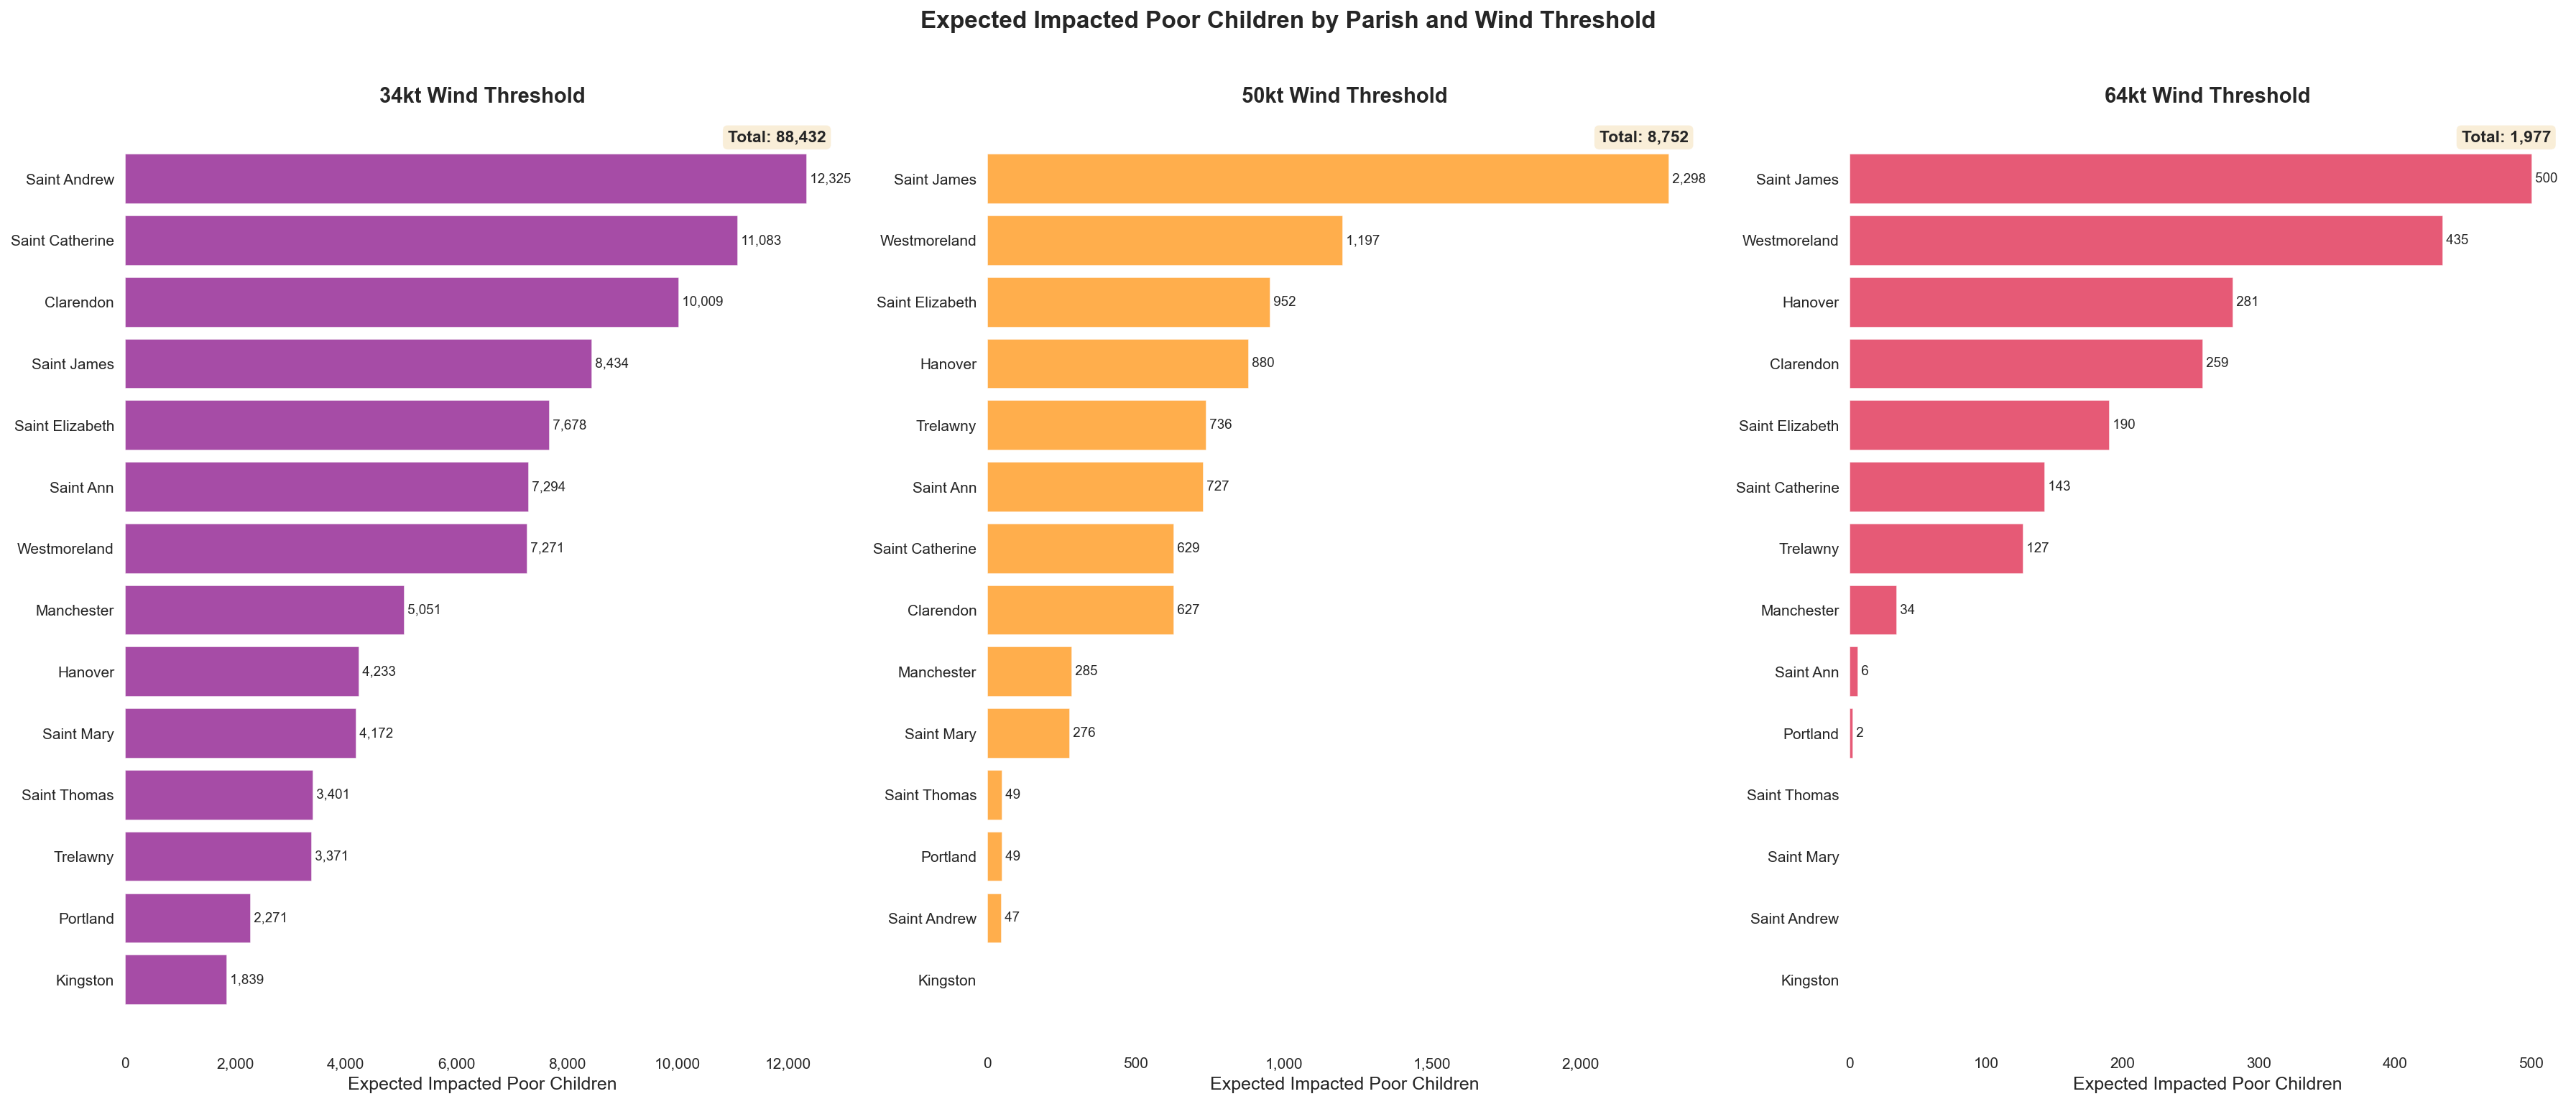

  Saved: analysis_output/visualizations/expected_impacted_poor_children_comparison_across_wind_thresholds_by_parish.png


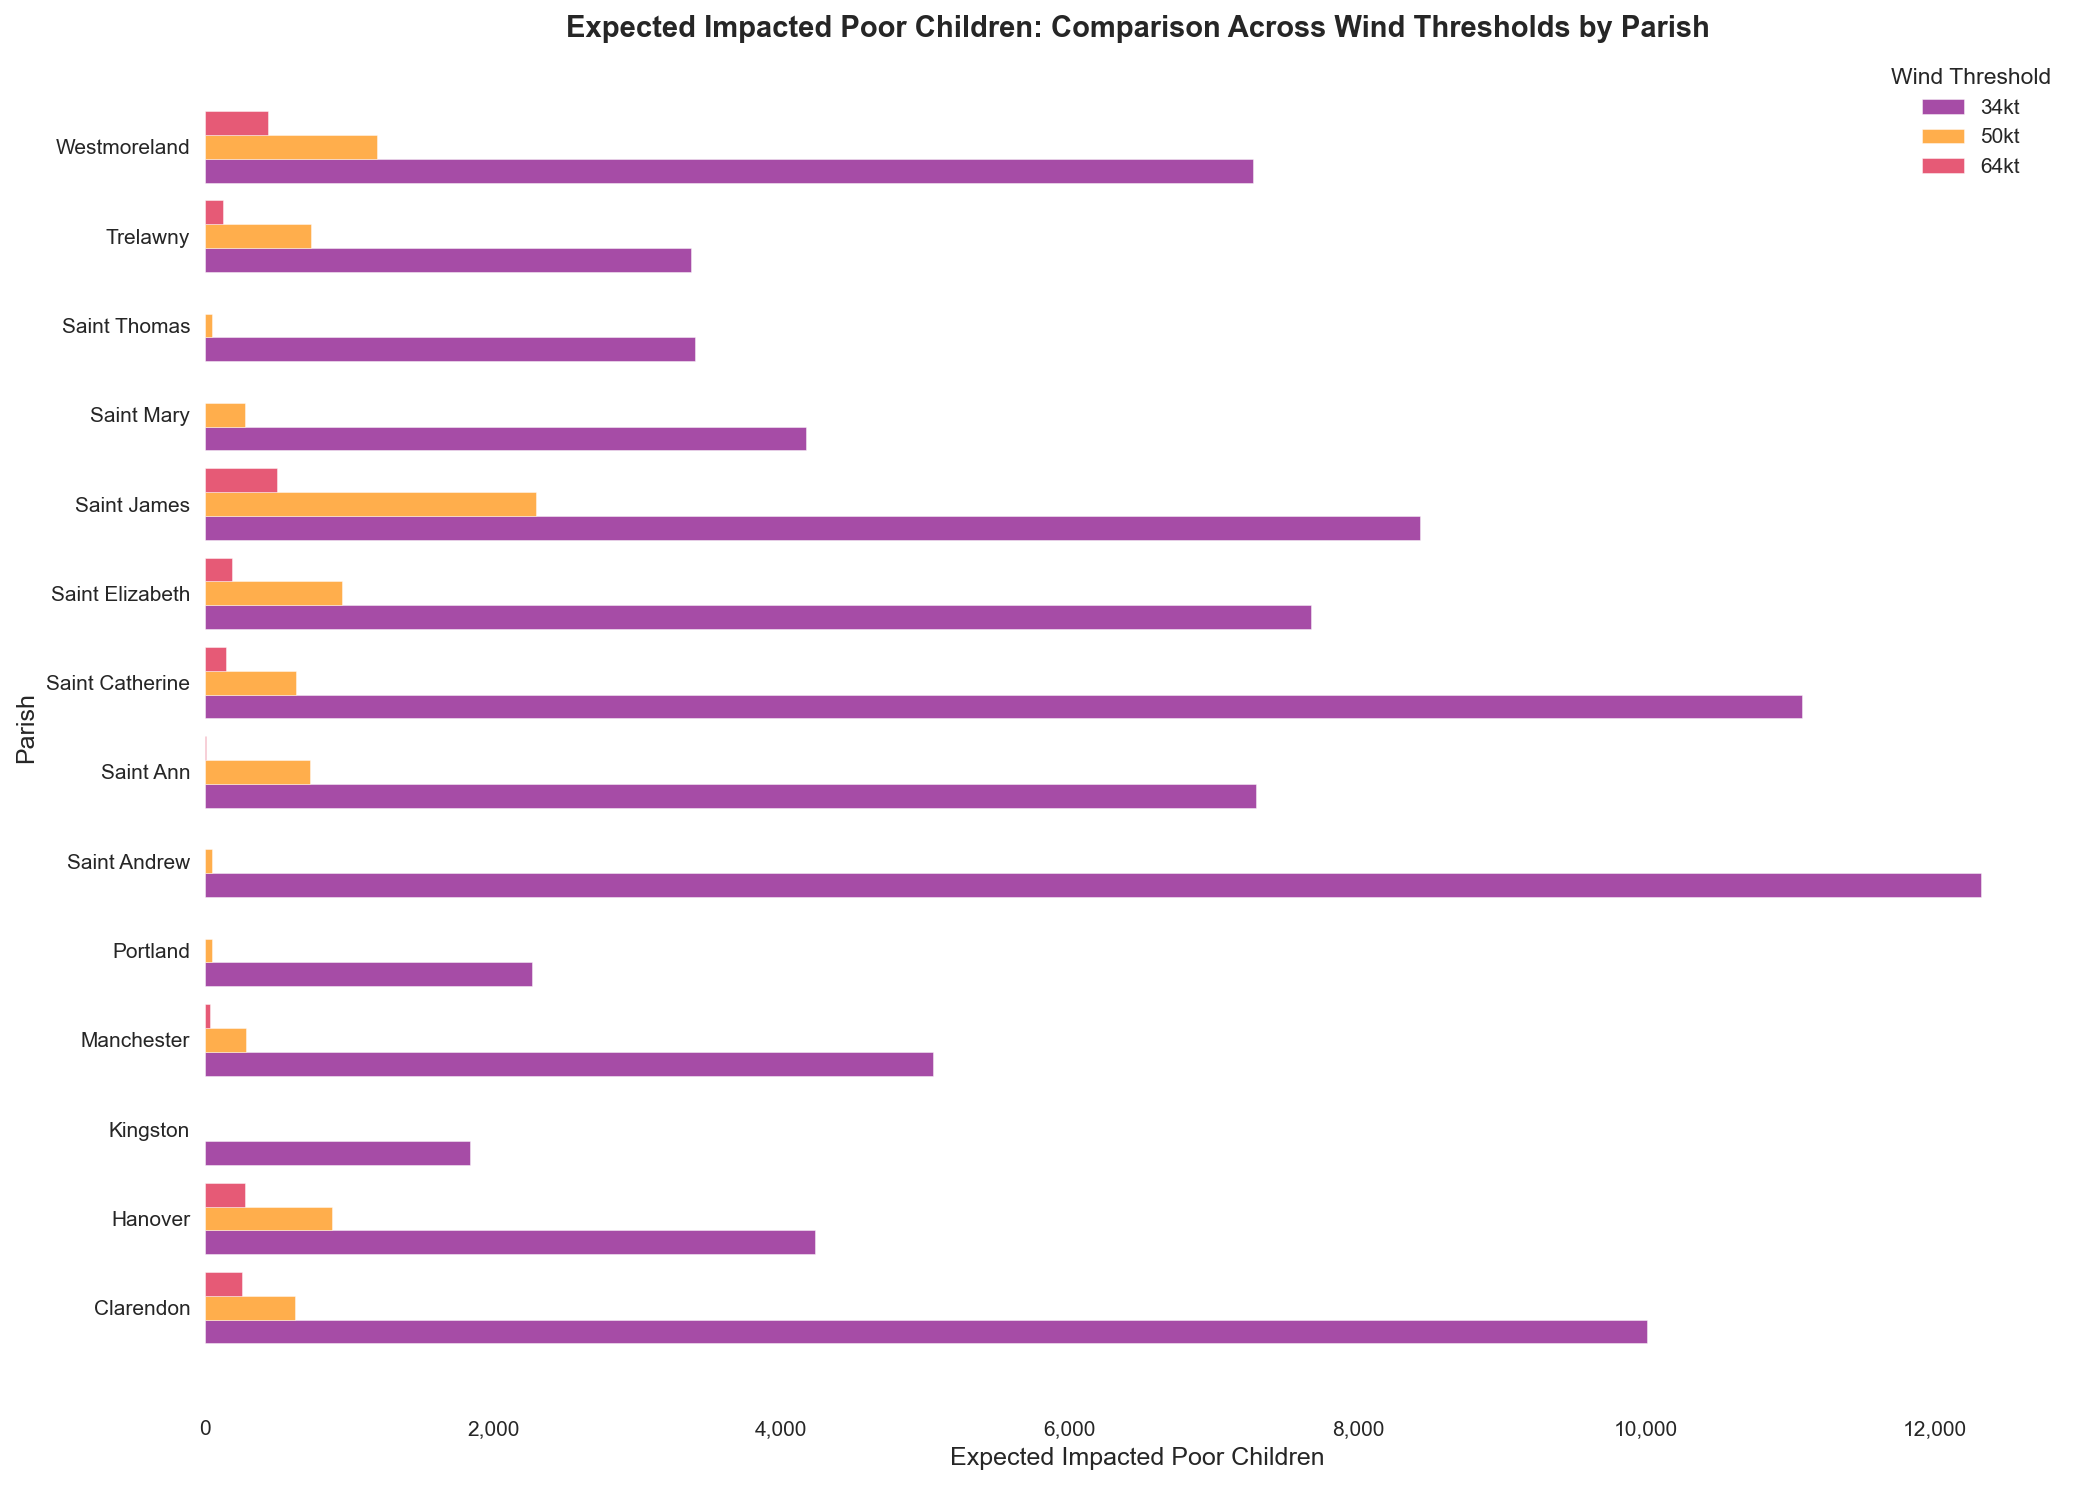

  Saved: analysis_output/visualizations/expected_impacted_poor_children_by_parish_map_view.png


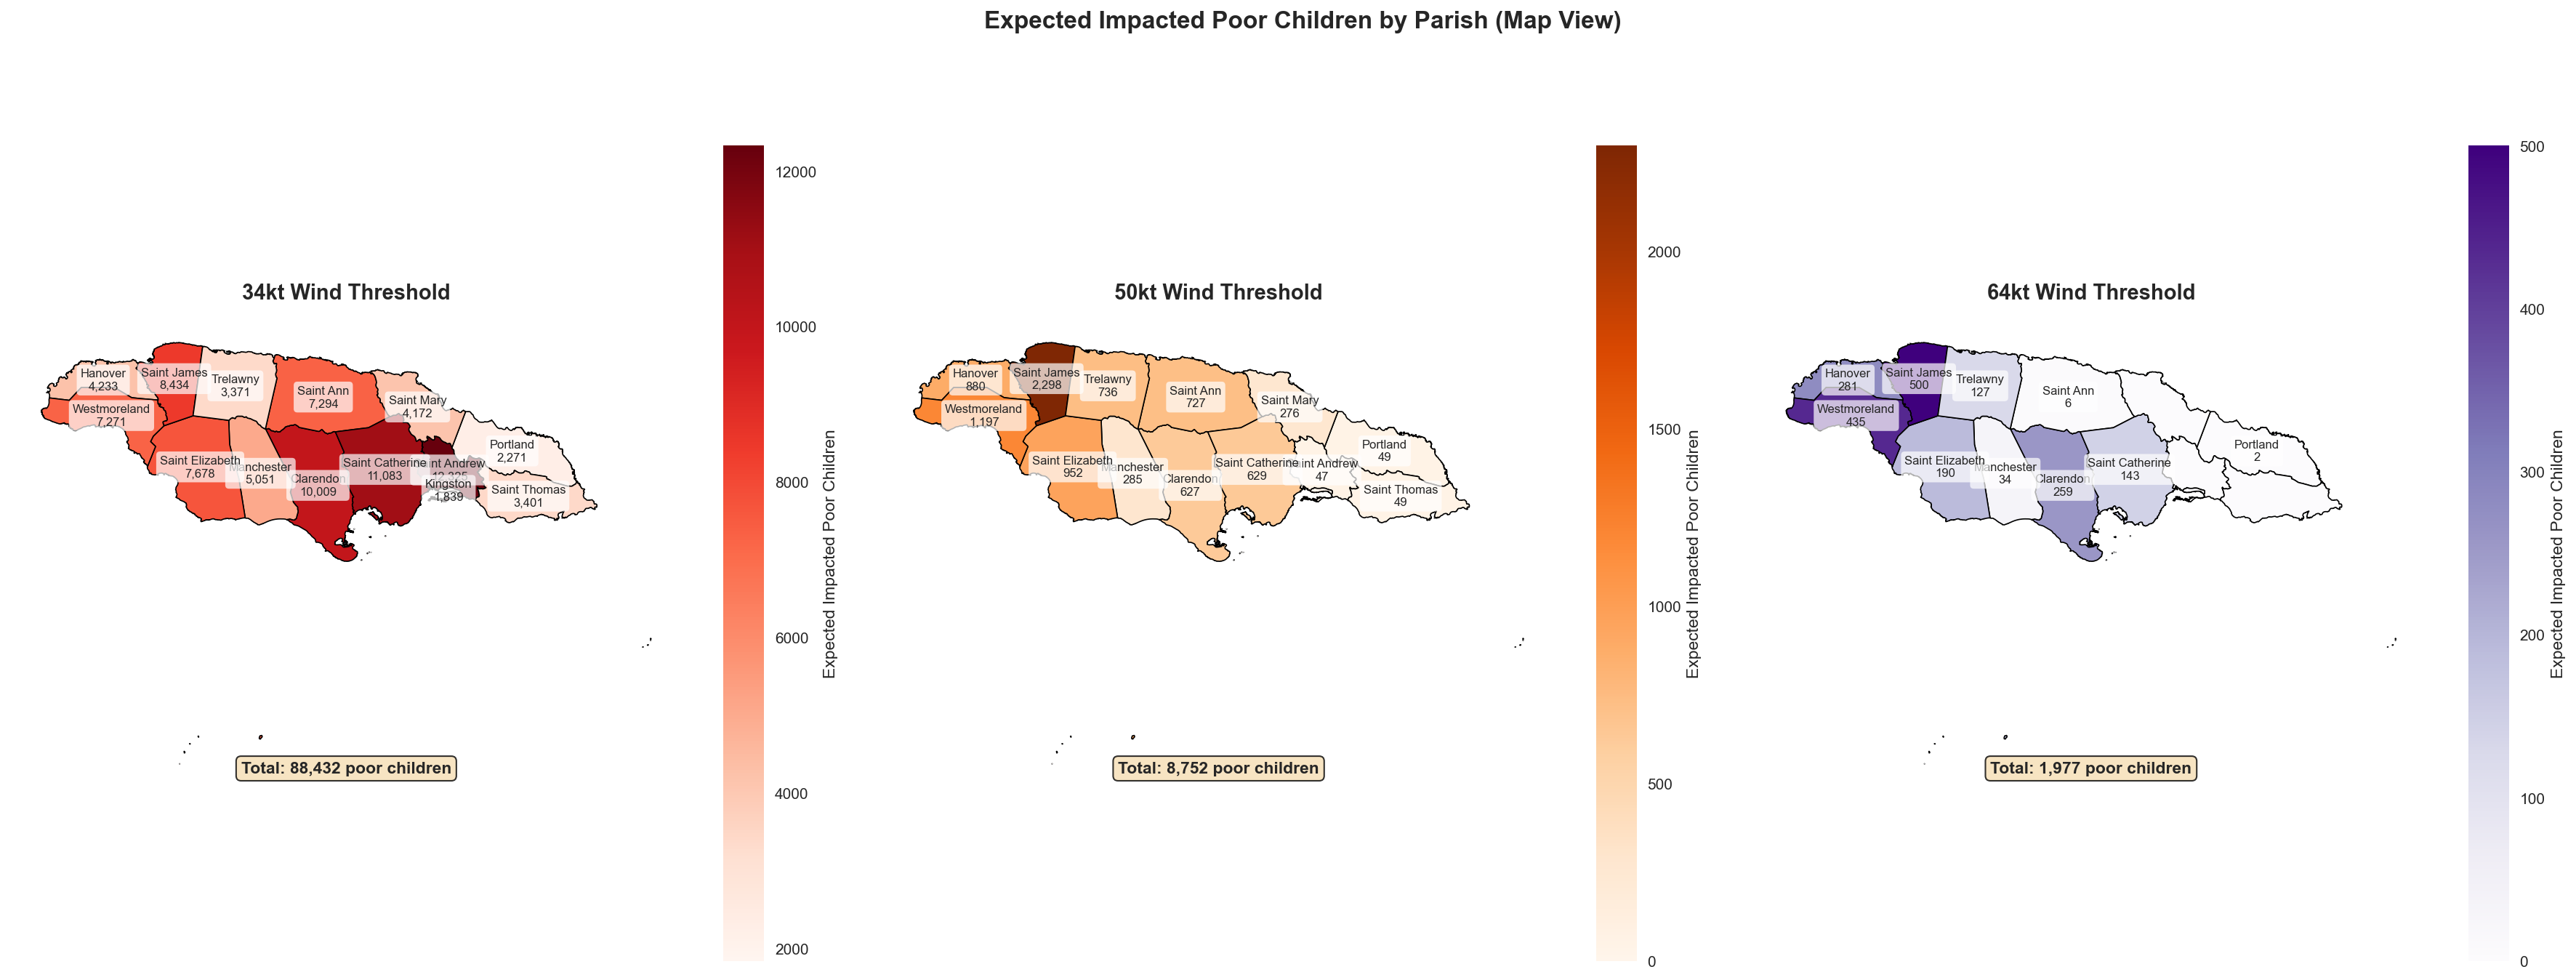

In [18]:
# Check if we have impact data (either from tile-level files or configured thresholds)
has_impact_data = (DATE and FORECAST_TIME and WIND_THRESHOLDS and STORM and 
                   any(f'potentially_impacted_poor_children_{wt}kt' in gdf_results.columns 
                       for wt in WIND_THRESHOLDS))

if has_impact_data:
    # Aggregate by parish (ALL tiles contribute proportionally in sigmoid approach)
    parish_impact_summary = []
    
    for parish_name in sorted(gdf_results['parish'].unique()):
        parish_tiles = gdf_results[gdf_results['parish'] == parish_name]
        
        if len(parish_tiles) > 0:
            row = {
                'parish': parish_name,
                'total_tiles': len(parish_tiles),
                'poor_children': parish_tiles['poor_children'].sum()
            }
            
            # Add impact data for each threshold
            for wind_threshold in WIND_THRESHOLDS:
                impact_col = f'potentially_impacted_poor_children_{wind_threshold}kt'
                if impact_col in parish_tiles.columns:
                    row[impact_col] = parish_tiles[impact_col].sum()
                else:
                    row[impact_col] = 0
            
            parish_impact_summary.append(row)
    
    df_parish_impact = pd.DataFrame(parish_impact_summary)
    
    print(f"\nParish Impact Summary:")
    print(df_parish_impact[['parish', 'total_tiles', 'poor_children']].to_string(index=False))
    
    # Create visualizations per parish for each wind threshold
    impact_pop_cols = [col for col in df_parish_impact.columns if col.startswith('potentially_impacted_poor_children_')]
    
    if impact_pop_cols:
        # Determine layout based on number of thresholds
        n_thresholds = len(impact_pop_cols)
        
        if n_thresholds == 1:
            fig, axes = plt.subplots(1, 1, figsize=(14, 10))
            axes = [axes]
        elif n_thresholds == 2:
            fig, axes = plt.subplots(1, 2, figsize=(20, 10))
        elif n_thresholds == 3:
            fig, axes = plt.subplots(1, 3, figsize=(24, 10))
        else:
            n_cols = 3
            n_rows = (n_thresholds + n_cols - 1) // n_cols
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 6*n_rows))
            axes = axes.flatten()
        
        colors = ['purple', 'darkorange', 'crimson', 'teal', 'navy', 'maroon']
        
        for idx, impact_col in enumerate(impact_pop_cols):
            ax = axes[idx]
            threshold = impact_col.replace('potentially_impacted_poor_children_', '').replace('kt', '')
            
            # Sort by impact poor children
            df_plot = df_parish_impact.sort_values(impact_col, ascending=True)
            
            # Create horizontal bar chart
            bars = ax.barh(df_plot['parish'], df_plot[impact_col], color=colors[idx % len(colors)], alpha=0.7)
            
            # Add value labels on bars
            for i, (bar, val) in enumerate(zip(bars, df_plot[impact_col])):
                if val > 0:
                    ax.text(val, i, f' {val:,.0f}', va='center', fontsize=9)
            
            ax.set_xlabel('Expected Impacted Poor Children', fontsize=12)
            ax.set_title(f'{threshold}kt Wind Threshold', fontsize=14, fontweight='bold')
            ax.grid(axis='x', alpha=0.3)
            ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
            
            # Add total at the top
            total = df_parish_impact[impact_col].sum()
            ax.text(0.98, 0.98, f'Total: {total:,.0f}', 
                   transform=ax.transAxes, ha='right', va='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                   fontsize=11, fontweight='bold')
        
        # Hide unused subplots
        for idx in range(n_thresholds, len(axes)):
            axes[idx].axis('off')
        
        plt.suptitle('Expected Impacted Poor Children by Parish and Wind Threshold',
                     fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
        
        # Create side-by-side comparison
        fig, ax = plt.subplots(figsize=(14, 10))
        
        parishes = df_parish_impact['parish'].values
        x = np.arange(len(parishes))
        width = 0.8 / n_thresholds
        
        for idx, impact_col in enumerate(impact_pop_cols):
            threshold = impact_col.replace('potentially_impacted_poor_children_', '').replace('kt', '')
            values = df_parish_impact[impact_col].values
            offset = (idx - (n_thresholds - 1) / 2) * width
            ax.barh(x + offset, values, width, label=f'{threshold}kt', 
                   color=colors[idx % len(colors)], alpha=0.7)
        
        ax.set_xlabel('Expected Impacted Poor Children', fontsize=12)
        ax.set_ylabel('Parish', fontsize=12)
        ax.set_title('Expected Impacted Poor Children: Comparison Across Wind Thresholds by Parish',
                    fontsize=14, fontweight='bold')
        ax.set_yticks(x)
        ax.set_yticklabels(parishes)
        ax.legend(title='Wind Threshold', fontsize=10, title_fontsize=11)
        ax.grid(axis='x', alpha=0.3)
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
        
        plt.tight_layout()
        plt.show()


        
        # Create map visualizations for expected impacted poor children by parish (AGGREGATED)
        
        # Aggregate impact data by parish from tiles (ALL tiles contribute proportionally)
        parish_impact_map = {}
        for wind_threshold in WIND_THRESHOLDS:
            impact_col = f'potentially_impacted_poor_children_{wind_threshold}kt'
            if impact_col in gdf_results.columns:
                parish_impact_map[impact_col] = gdf_results.groupby('parish')[impact_col].sum().to_dict()
        
        # Create a DataFrame with parish impact data
        df_parish_impact_map = pd.DataFrame(parish_impact_map)
        df_parish_impact_map = df_parish_impact_map.reset_index()
        df_parish_impact_map = df_parish_impact_map.rename(columns={'index': 'parish'})
        
        # Join impact data to admin boundaries for mapping
        gdf_admin_impact = gdf_admin.merge(df_parish_impact_map, left_on='name', right_on='parish', how='left')
        
        # Determine layout based on number of thresholds
        if n_thresholds == 1:
            fig, axes = plt.subplots(1, 1, figsize=(12, 10))
            axes = [axes]
        elif n_thresholds == 2:
            fig, axes = plt.subplots(1, 2, figsize=(20, 10))
        elif n_thresholds == 3:
            fig, axes = plt.subplots(1, 3, figsize=(24, 10))
        else:
            n_cols = 3
            n_rows = (n_thresholds + n_cols - 1) // n_cols
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(10*n_cols, 8*n_rows))
            axes = axes.flatten()
        
        colormaps = ['Reds', 'Oranges', 'Purples', 'Blues', 'Greens', 'YlOrRd']
        
        for idx, impact_col in enumerate(impact_pop_cols):
            ax = axes[idx]
            threshold = impact_col.replace('potentially_impacted_poor_children_', '').replace('kt', '')
            
            # Plot admin boundaries colored by potentially impacted poor children
            gdf_admin_impact.plot(
                ax=ax,
                column=impact_col,
                cmap=colormaps[idx % len(colormaps)],
                edgecolor='black',
                linewidth=0.8,
                legend=True,
                legend_kwds={
                    'label': 'Expected Impacted Poor Children',
                    'shrink': 0.8
                },
                missing_kwds={
                    'color': 'lightgray',
                    'edgecolor': 'black',
                    'hatch': '///',
                    'label': 'No data'
                }
            )
            
            # Add parish labels
            for idx_parish, row in gdf_admin_impact.iterrows():
                if pd.notna(row[impact_col]) and row[impact_col] > 0:
                    centroid = row.geometry.centroid
                    ax.text(
                        centroid.x, centroid.y,
                        f"{row['name']}\n{row[impact_col]:,.0f}",
                        ha='center', va='center',
                        fontsize=8,
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none')
                    )
            
            ax.set_title(f'{threshold}kt Wind Threshold', fontsize=14, fontweight='bold', pad=15)
            ax.set_xlabel('Longitude', fontsize=11)
            ax.set_ylabel('Latitude', fontsize=11)
            ax.axis('off')
            
            # Add total at the bottom
            total = df_parish_impact[impact_col].sum()
            ax.text(0.5, 0.02, f'Total: {total:,.0f} poor children', 
                   transform=ax.transAxes, ha='center', va='bottom',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, edgecolor='black', linewidth=1),
                   fontsize=11, fontweight='bold')
        
        # Hide unused subplots
        for idx in range(n_thresholds, len(axes)):
            axes[idx].axis('off')
        
        plt.suptitle('Expected Impacted Poor Children by Parish (Map View)',
                     fontsize=16, fontweight='bold', y=0.98)
        plt.tight_layout()
        plt.show()
        
    else:
        print("No impact probability columns found in parish data")
else:
    print("No impact probability data available for parish-level visualization")


## Export Results


In [19]:
# Export the results
output_dir = "analysis_output"
os.makedirs(output_dir, exist_ok=True)

# Export tiles with poor children (sigmoid approach: all tiles contribute proportionally)
output_file = os.path.join(output_dir, f"poor_children_cells.geojson")
try:
    # Export all tiles with poor_children > 0
    gdf_results[gdf_results['poor_children'] > 0].to_file(output_file, driver='GeoJSON')
    print(f"Exported poor children cells to: {output_file}")
except PermissionError:
    print(f"Warning: Could not export to {output_file} (permission error)")

# Export all tiles with poverty probabilities and poor children
all_tiles_file = os.path.join(output_dir, f"all_tiles_with_poor_children_flag.parquet")
gdf_results.to_parquet(all_tiles_file)
print(f"Exported all tiles to: {all_tiles_file}")

# Create summary statistics by classification
summary_data = []
for classification in ['Rural', 'Urban', 'KMA']:
    mask = gdf_results['area_classification'] == classification
    region_data = gdf_results[mask]
    
    if len(region_data) > 0:
        row = {
            'classification': classification,
            'total_cells': len(region_data),
            'total_children_population': region_data['children_population'].sum(),
            'total_poor_children': region_data['poor_children'].sum(),
            'avg_poverty_rate': region_data['poverty_prob'].mean(),
            'cells_with_poor_children': (region_data['poor_children'] > 0).sum()
        }
        
        # Add impact data if available
        if DATE and FORECAST_TIME and WIND_THRESHOLDS:
            for wind_threshold in WIND_THRESHOLDS:
                impact_col = f'potentially_impacted_poor_children_{wind_threshold}kt'
                if impact_col in region_data.columns:
                    row[impact_col] = region_data[impact_col].sum()
        
        summary_data.append(row)

# Create summary dataframe
df_summary = pd.DataFrame(summary_data)

# Export summary statistics
summary_file = os.path.join(output_dir, f"poor_children_selection_summary.csv")
df_summary.to_csv(summary_file, index=False)
print(f"Exported summary statistics to: {summary_file}")

# Export parish impact summary if available
if 'df_parish_impact' in locals():
    parish_impact_file = os.path.join(output_dir, f"poor_children_parish_impact_summary.csv")
    df_parish_impact.to_csv(parish_impact_file, index=False)
    print(f"Exported parish impact summary to: {parish_impact_file}")


Exported poor children cells to: analysis_output/poor_children_cells.geojson
Exported all tiles to: analysis_output/all_tiles_with_poor_children_flag.parquet
Exported summary statistics to: analysis_output/poor_children_selection_summary.csv
Exported parish impact summary to: analysis_output/poor_children_parish_impact_summary.csv
